# K Giants
## MSP, 8.4.2019


In [1]:
# standard python modules
import numpy as np
import time
import copy



# plotting utilities
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

cmap = mpl.cm.inferno


import scipy.interpolate as interpolate


import subprocess



In [2]:
# exptool imports
from exptool.basis import eof
from exptool.basis import spheresl
from exptool.basis import *

#from exptool.basis import spheresl_new


from ssl import *
from exptool.io import psp_io

from exptool.analysis import pattern
from exptool.analysis import trapping


mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

from exptool.utils import *


stylepar='medium'

if stylepar == 'medium':
    mpl.rcParams['font.weight'] = 'medium'
    mpl.rcParams['axes.linewidth'] = 1.5
    mpl.rcParams['xtick.major.width'] = 1.5
    mpl.rcParams['xtick.minor.width'] = 0.75
    mpl.rcParams['xtick.minor.visible'] = True
    mpl.rcParams['ytick.major.width'] = 1.5
    mpl.rcParams['ytick.minor.width'] = 0.75
    mpl.rcParams['ytick.minor.visible'] = True







In [3]:
# follow along here

# http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame.html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py

import astropy.coordinates as coord
import astropy.units as u

In [4]:

X14 = np.genfromtxt('data/Xue2014.txt',\
                        dtype={'names': ("RA","Dec","rmag","ermag",\
                                         "gr","egr","HRV","eHRV",\
                                         "Teff","FeH","eFeH","logg",\
                                         "DMpeak","DM05","DM16","DM50",\
                                         "DM85","DM95","DMerror","rMag","erMag",\
                                         "d","ed","rGC","erGC",\
                                         "Pabove"),\
                             'formats': ('f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8')},\
                 skip_header=47)




OSError: Xue2014full.txt not found.

In [16]:

#_Glon;_Glat;SDSS;RAJ2000;DEJ2000;rmag;g-r;HRV;Teff;[Fe/H];logg;DMpeak;rMag;Dist;Rgc;pRGB;Sloan;SimbadName

X15 = np.genfromtxt('data/Xue2014KGiant.txt',\
                        dtype={'names': ("Glon","Glat","SDSS","RA","Dec",\
                                         "rmag","gr","HRV","Teff",\
                                         "FeH","logg","DMpeak","rMag",\
                                         "d","Rgc","pRGB",\
                                         "Sloan","SimbadName"),\
                             'formats': ('f8','f8','S20','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8',\
                                        'S20','S20')},\
                 skip_header=69,delimiter=';')


# hand-make the matching table
f = open('processed/matchingKgiants.txt','w')

print('name, ra,  dec,',file=f)

for x in range(0,len(X15['RA'])):
    print('S'+str(x),',',X15['RA'][x],',',X15['Dec'][x],',',file=f)

f.close()

X15m = np.genfromtxt('processed/matchingKgiants.txt',\
                    dtype={'names': ('Name','ra','dec'),\
                          'formats': ('S20','f8','f8')},\
                    skip_header=1,delimiter=',')


GmatchO = np.genfromtxt('data/Xue2015KGiantxmatch_gaia.txt',\
                        dtype={'names': ("xsource_id","gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","aen","dist"),\
                             'formats': ('S20','S20','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')



Gmatch = np.genfromtxt('data/Xue2015KGiantxmatch_gaia_corr.txt',\
                        dtype={'names': ("xsource_id","gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","pmcorr","dist"),\
                             'formats': ('S20','S20','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')

# there is a uniqueness problem that requires additional matching.

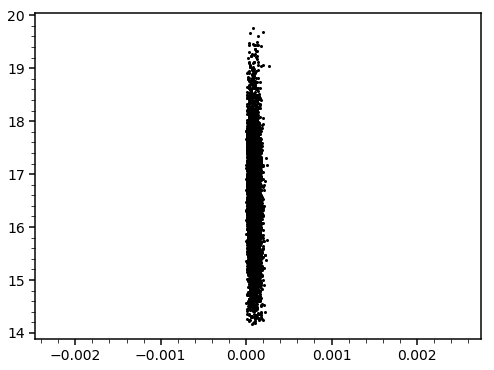

In [17]:
plt.scatter(Gmatch['dist'],Gmatch['phot_g_mean_mag'],color='black',s=4.)



In [19]:
# need to double check all this matching...something doesn't seem right.
decoded_names = np.array([int((X15m['Name'][x].decode()).strip('S')) for x in range(0,X15m['Name'].size)])

# do the cross-matching to the original Xue sample
# everything is therefore matched to the X11 sample


# can take all the X11 data
grvals = X15["gr"]


gaiadict = {}

matchlist = ["gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","pmcorr","dist"]

for match in matchlist:
    gaiadict['g'+match] = np.zeros(grvals.size)
    


# this performs the matching. loop over each source...
for indx,val in enumerate(decoded_names):
    

    #print(X15m['Name'][indx])
    # add the gaia data
    try:
        pass
        for match in matchlist:
            # identify by matching the name down the list.
            
            gaiadict['g'+match][val] = Gmatch[match][Gmatch['xsource_id']==X15m['Name'][indx].strip()]
    except:
        print('Failure')
    



Failure
Failure
Failure
Failure


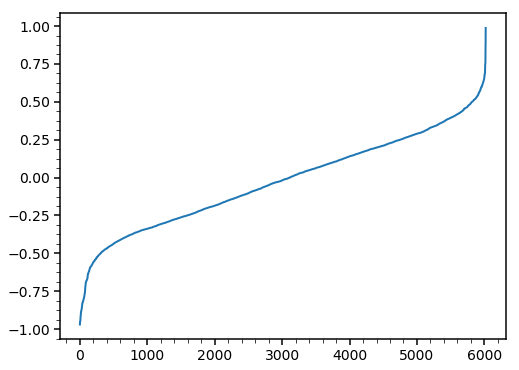

In [20]:

closeness = gaiadict['gpmcorr']
plt.plot(closeness[closeness.argsort()])


Text(0.5, 1.0, 'Correlation for stars at $>$50 kpc')

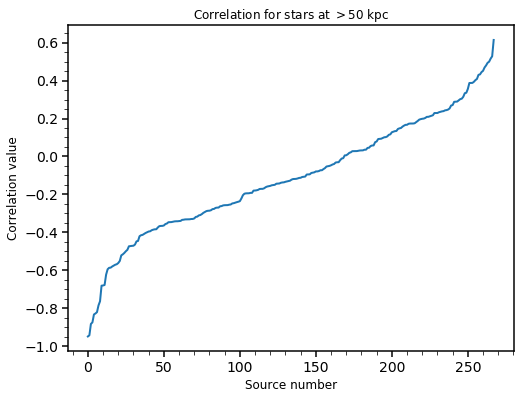

In [21]:
# check how strong the velocity correlations are
distsize = gaiadict['gpmcorr'][X15['d']>50]

plt.plot(distsize[distsize.argsort()])

plt.xlabel('Source number',size=12)
plt.ylabel('Correlation value',size=12)
plt.title('Correlation for stars at $>$50 kpc',size=12)

In [53]:
gaiadict['gra'][bigd][0]

215.71553212777323

In [58]:
coord.galactic

AttributeError: module 'astropy.coordinates' has no attribute 'galactic'

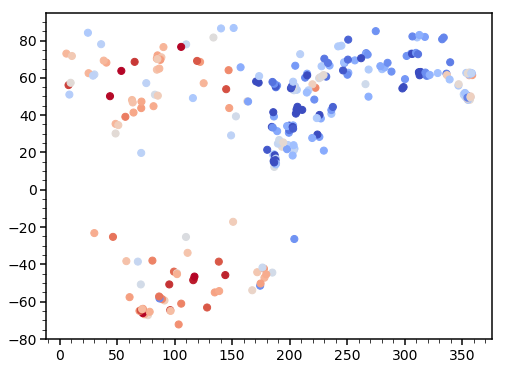

In [22]:
bigd = [X15['d']>50]

c = coord.SkyCoord(ra=gaiadict['gra'][bigd]*u.deg,\
                   dec=gaiadict['gdec'][bigd]*u.deg,\
                   pm_ra_cosdec=gaiadict['gpmra'][bigd]*u.mas/u.yr,\
                   pm_dec=gaiadict['gpmdec'][bigd]*u.mas/u.yr)


plt.scatter(np.array(c.galactic.l),np.array(c.galactic.b),color=cm.coolwarm((gaiadict['gpmcorr'][bigd]+0.5),1.),s=50.)

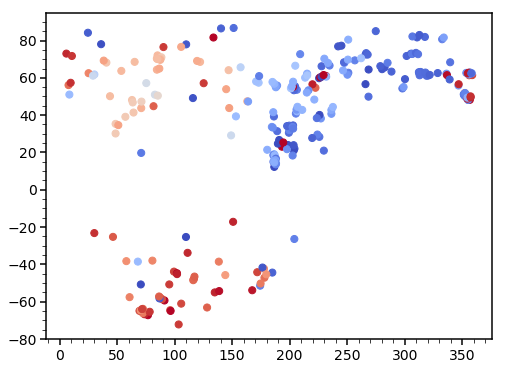

In [26]:
plt.scatter(np.array(c.galactic.l),np.array(c.galactic.b),color=cm.coolwarm((userot+1.5)/3.,1.),s=50.)

346.73991968540514 55.873876110654784 -1.4896063514411604 1.918656471452981


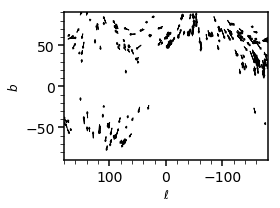

In [67]:
i = 0
r = 15.*gaiadict['gpmcorr'][bigd]
x,y = np.array(c.galactic.l)[i],np.array(c.galactic.b)[i]
dx,dy = r[i]*np.cos(userot[i]),r[i]*np.sin(userot[i])

print(x,y,dx,dy)

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

for i in range(0,userot.size):
    x,y = np.array(c.galactic.l)[i],np.array(c.galactic.b)[i]
    if x>180.: x-=360.
    dx,dy = r[i]*np.cos(newrot[i]),r[i]*np.sin(newrot[i])
    ax.arrow(x,y,dx,dy, head_width=2.5, head_length=2.1, fc='k', ec='k')

ax.axis([180.,-180.,-90.,90.])

ax.set_xlabel('$\ell$',size=12)
ax.set_ylabel('$b$',size=12)
plt.tight_layout()
plt.savefig('figures/KGiant_error_correlations.png',dpi=300)

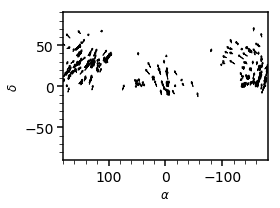

In [57]:
r = 15.*gaiadict['gpmcorr'][bigd]

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

for i in range(0,userot.size):
    x,y = gaiadict['gra'][bigd][i],gaiadict['gdec'][bigd][i]
    if x>180.: x-=360.
    dx,dy = r[i]*np.cos(userot[i]),r[i]*np.sin(userot[i])
    ax.arrow(x,y,dx,dy, head_width=2.5, head_length=2.1, fc='k', ec='k')

ax.axis([180.,-180.,-90.,90.])

ax.set_xlabel('$\\alpha$',size=12)
ax.set_ylabel('$\\delta$',size=12)
plt.tight_layout()
plt.savefig('figures/KGiant_error_correlations_alphadelta.png',dpi=300)

In [59]:
# see https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html


def return_gaia_Agprime():
    """return the matrix in eq 3.61, key to transform from ICRS to galactic coordinates"""
    return np.array([[-0.0548755604162154,-0.8734370902348850,-0.4838350155487132],
                     [+0.4941094278755837,-0.4448296299600112,+0.7469822444972189],
                     [-0.8676661490190047,-0.1980763734312015,+0.4559837761750669]])

def return_ricrs(a,d):
    """ eq."""
    return np.array([np.cos(a)*np.cos(d),np.sin(a)*np.cos(d),np.sin(d)]).T

def return_picrs(a,d):
    """ eq. 3.64, unit vector of increasing alpha"""
    return np.array([-np.sin(a),np.cos(a),0.]).T

def return_qicrs(a,d):
    """ eq. 3.64, unit vector of increasing delta"""
    return np.array([-np.cos(a)*np.sin(d),-np.sin(a)*np.sin(d),0.]).T

def return_rgal(l,b):
    """ eq."""
    return np.array([np.cos(l)*np.cos(b),np.sin(l)*np.cos(b),np.sin(b)]).T

def return_pgal(l,b):
    """ eq. 3.66, unit vector of increasing alpha"""
    return np.array([-np.sin(l),np.cos(l),0.]).T

def return_qgal(l,b):
    """ eq. 3.66, unit vector of increasing delta"""
    return np.array([-np.cos(l)*np.sin(b),-np.sin(l)*np.sin(b),0.]).T





def rotate_errors(a,d,pmra_e,pmdec_e,pmcorr):
    ricrs = return_ricrs(a,d)
    picrs = return_picrs(a,d)
    qicrs = return_qicrs(a,d)

    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    #rgal = return_rgal(ell,b)
    pgal = return_pgal(ell,b)
    qgal = return_qgal(ell,b)

    pqgal = np.stack((pgal, qgal), axis=-1)
    pqicrs = np.stack((picrs, qicrs), axis=-1)

    cov = np.array([[pmra_e*pmra_e,pmra_e*pmdec_e*pmcorr],[pmra_e*pmdec_e*pmcorr,pmdec_e*pmdec_e]])
    #print(cov)

    G = np.einsum('ab,ac->bc', pqgal,
                      np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs))

    cov_to = np.einsum('ba,ac->bc', G,
                           np.einsum('ij,ki->jk', cov, G))
    
    return cov_to

#print(G)


a = 45.*np.pi/180.
d = 45.*np.pi/180.


cov_to = rotate_errors(a,d,1,2.,-0.25)
print(cov_to)


#print(ricrs,rgal,ell,b)

[[1.21186271 0.13875855]
 [0.13875855 0.0301345 ]]


In [66]:
bd = np.where(X15['d']>50)
newrot = np.zeros(len(bd[0]))

for i in range(0,len(bd[0])):
    e1 = gaiadict['gpmra_error'][bigd][i]
    e2 = gaiadict['gpmdec_error'][bigd][i]
    e3 = gaiadict['gpmcorr'][bigd][i]
    cov_to = rotate_errors(gaiadict['gra'][bigd][i]*np.pi/180.,gaiadict['gdec'][bigd][i]*np.pi/180.,\
                       e1,e2,e3)

    newrot[i] = 0.5*np.arctan2(2*cov_to[0][1],cov_to[1][1]-cov_to[0][0])
    
print(newrot)

[-1.07739199  1.28403653 -1.24909438 -1.14674426 -1.15657914 -1.14266113
 -1.06942166  0.93153738  1.01477423 -1.36400982 -1.08895883  1.50468689
  1.09067967  1.05052888  1.03774833  1.0467912  -1.51878015  1.43522216
 -1.19763218 -1.16152188 -1.1769665  -1.15187752 -1.26775206 -0.8336489
  1.50439389  1.2783388   0.89439501 -1.02158645 -0.94099284  0.78067683
  1.11706299  0.75173807  1.15735197 -1.17788983  1.45007436  1.41020073
  1.05426125  1.07396895  1.13112591  1.13933069  0.38890031  1.09616925
 -0.96869868 -0.89737752  0.29169057  0.22127697  0.10383532 -0.05061834
 -0.0512293   0.01014772 -1.3341199   1.50815189 -1.57067085  1.45389232
 -1.23170021 -1.03185665 -0.5186272  -0.385573   -0.09274856  1.39308055
 -1.23646048 -1.29050022 -1.23155101  1.358581    1.5547759   1.50352059
 -1.54445154  1.50191     1.29013337  1.29938297 -0.8493639   1.45103657
 -1.49217311  1.35420303 -0.94036875 -0.72575668  0.52202072  0.47497021
  0.13402181  0.50949     1.22984398  1.15434257  1.

In [65]:
bigd

[array([False, False, False, ..., False, False, False])]

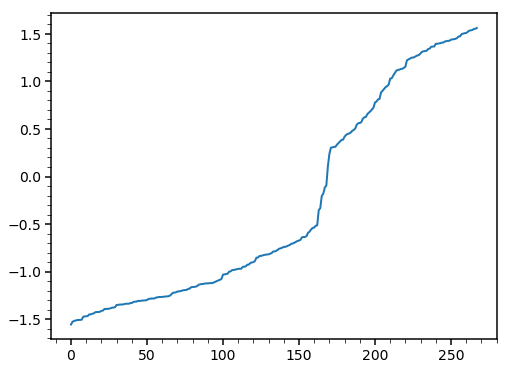

In [24]:
C33 = gaiadict['gpmra_error']*gaiadict['gpmra_error']
C44 = gaiadict['gpmdec_error']*gaiadict['gpmdec_error']
C34 = gaiadict['gpmra_error']*gaiadict['gpmdec_error']*gaiadict['gpmcorr']
rotation_axis = 0.5 * np.arctan2(2*C34,(C44-C33))

userot = rotation_axis[bigd]
plt.plot(userot[userot.argsort()])



In [52]:
cov = np.array([[C33, C34],
                 [C34, C44 ]])

gc.transform_pm_cov(c, cov, coord.Galactic)

NameError: name 'gc' is not defined

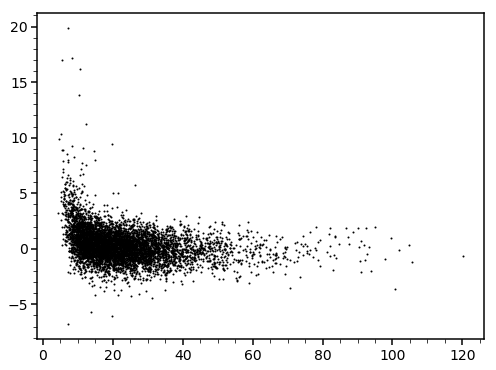

In [11]:
plt.scatter(X15['d'],gaiadict['gparallax']/gaiadict['gparallax_error'],color='black',s=1.)

In [12]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [16]:
sc = SkyCoord(gaiadict['gra']*u.deg, gaiadict['gdec']*u.deg,\
              pm_ra_cosdec=gaiadict['gpmra']*u.mas/u.yr, pm_dec=gaiadict['gpmdec']*u.mas/u.yr)


out = sc.galactic

[0.0, 360.0, -600.0, 600]

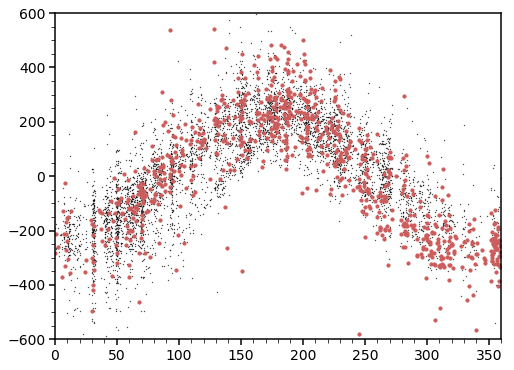

In [25]:
k = 4.74057

vl = out.pm_l_cosb*k*X15['d']

#plt.scatter(out.l,out.pm_l_cosb,color='black',s=0.1)
#plt.scatter(out.l[X15['d']>50],out.pm_l_cosb[X15['d']>50],color='indianred',s=10.)

plt.scatter(out.l,vl,color='black',s=0.1)
plt.scatter(out.l[X15['d']>35],vl[X15['d']>35],color='indianred',s=10.)

plt.axis([0.,360.,-600.,600])





## 

In [16]:
Cmatch = np.genfromtxt('/Users/mpetersen/Downloads/LAMOSTCarbon-result.csv',\
                        dtype={'names': ("xsource_id","gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","aen","dist"),\
                             'formats': ('S20','S20','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')




Text(0, 0.5, '$\\mu_{\\rm Dec}$ [marcsec/yr]')

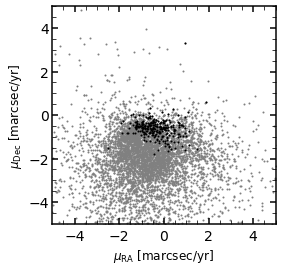

In [65]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.scatter(gaiadict['gpmra'],gaiadict['gpmdec'],color='gray',s=1.)


ax.scatter(gaiadict['gpmra'][X15['d']>50],gaiadict['gpmdec'][X15['d']>50],color='black',s=1.)

#ax.scatter(Cmatch['pmra'],Cmatch['pmdec'],color='red',s=2.)


ax.axis([-5.,5.,-5.,5.])

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis="y",which='both',direction="in")
ax.tick_params(axis="x",which='both',direction="in",pad=5)
ax.set_xlabel('$\\mu_{\\rm RA}$ [marcsec/yr]',size=12)
ax.set_ylabel('$\\mu_{\\rm Dec}$ [marcsec/yr]',size=12)


[0.0, 120.0, -3.5, 2.5]

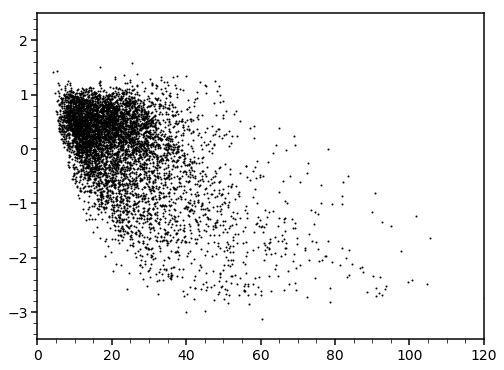

In [85]:
#plt.scatter(X15['d'],gaiadict['gphot_g_mean_mag'],color='black',s=1.)
#plt.axis([0.,120.,20.,13.])

# convert distance back into distance modulus...
DM = 5.*np.log10(100.*X15['d'])
plt.scatter(X15['d'],gaiadict['gphot_g_mean_mag']-DM,color='black',s=1.)

#mg = 

plt.axis([0.,120.,-3.5,2.5])

# what are lines of constant m_g on this?


In [ ]:
plt.scatter(gaiadict['gra'],gaiadict['gdec'],color='black',s=1.)

In [13]:
print(print(gaiadict['gpmra'][gaiadict['gpmra']==np.nan]))

[]
None


In [20]:
# set the magnitude limit
#keep = np.where(gaiag < 17.2)
#keep = np.where(psfg < 17.2)
#keep = np.where((X11['gmag'] < 17.0) & (X11['gr'] > -0.4) & (np.isnan(pmr)!=True)\
#                & (fehvals > -3.) & (np.isnan(radval)!=True) & (np.abs(raval-X11['RA'])<0.1))

#keep = np.where((X11['gmag'] < 19.0) & (X11['gr'] > -0.4) & (np.isnan(pmr)!=True)\
#                & (fehvals > -3.) & (np.isnan(radval)!=True) & (np.abs(raval-X11['RA'])<0.1))

keep = np.where(gaiadict['gphot_g_mean_mag'])[0]

print(keep.size)



6032


In [288]:

V19 = np.genfromtxt('data/Vasiliev19.txt',\
                        dtype={'names': ("Name","OName","ra","dec",\
                                         "dist","HRV","e_HRV","pmra",\
                                         "pmdec","e_pmra","e_pmdec","corr",\
                                         "rscale","Nstar","SimbadName"),\
                             'formats': ('S20','S20','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','S20')},\
                 skip_header=61,delimiter=';')




def make_gc_dist(V19,indx,nsamples=10000,verbose=False):
    ra = V19['ra'][indx]
    dec = V19['dec'][indx]
    d = V19['dist'][indx]
    derr = 0.02*V19['dist'][indx]
    pmra = V19['pmra'][indx]
    pmraerr = V19['e_pmra'][indx]
    pmdec = V19['pmdec'][indx]
    pmdecerr = V19['e_pmdec'][indx]
    vrad = V19['HRV'][indx]
    vraderr = V19['e_HRV'][indx]

    cplus = coord.SkyCoord(ra              = np.tile(ra,nsamples)                                 * u.deg,\
                           dec             = np.tile(dec,nsamples)                                 * u.deg,\
                           distance        = np.nanmax([np.zeros(nsamples)+.1,(d     + np.random.normal(size=nsamples)*derr)],axis=0)     * u.kpc,\
                           pm_ra_cosdec    = (pmra  + np.random.normal(size=nsamples)*pmraerr)  * u.mas/u.yr,\
                           pm_dec          = (pmdec + np.random.normal(size=nsamples)*pmdecerr) * u.mas/u.yr,\
                           radial_velocity = (vrad  + np.random.normal(size=nsamples)*vraderr)  * u.km/u.s)

    cbest = coord.SkyCoord(ra              = ra    * u.deg,\
                           dec             = dec   * u.deg,\
                           distance        = d     * u.kpc,\
                           pm_ra_cosdec    = pmra  * u.mas/u.yr,\
                           pm_dec          = pmdec * u.mas/u.yr,\
                           radial_velocity = vrad  * u.km/u.s)

    if verbose:
        print(pmra,pmdec,vrad)

    gal_latlon  = cplus.transform_to('galactic')
    gal_defined = cplus.transform_to(gc_frame)
        
    best_latlon  = cbest.transform_to('galactic')
    best_defined = cbest.transform_to(gc_frame)
    
    return gal_latlon,gal_defined,best_latlon,best_defined


indx = 40
gal_latlon,gal_defined,best_latlon,best_defined = make_gc_dist(V19,indx,nsamples=1000,verbose=True)





-4.002 -3.064 -6.0


In [289]:


f = open('/Users/mpetersen/Dropbox/mike/data/GCs_cartesian_galactocentric.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     phi1 [deg]; phi2 [deg]; radius [kpc]; vgsr [km/s]; dmuphi1 [marcsec/yr]; dmuphi2 [marcsec/yr]; \
      eradius[kpc]; evgsr [km/s]; edmuphi1 [marcsec/yr]; edmuphi2 [marcsec/yr]',file=f)


g = open('/Users/mpetersen/Dropbox/mike/data/GCs_cartesian_heliocentric.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr]; \
      edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr]',file=g)




for indx,i in enumerate(np.arange(0,len(V19['ra']),1)):

    gal_latlon,gal_defined,best_latlon,best_defined = make_gc_dist(V19,indx,nsamples=1000,verbose=True)

    dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x),\
                                                  np.array(best_defined.y),\
                                                  np.array(best_defined.z),\
                                                  np.array(best_defined.v_x),\
                                                  np.array(best_defined.v_y),\
                                                  np.array(best_defined.v_z))

    edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x),\
                                                  np.array(gal_defined.y),\
                                                  np.array(gal_defined.z),\
                                                  np.array(gal_defined.v_x),\
                                                  np.array(gal_defined.v_y),\
                                                  np.array(gal_defined.v_z))
   

    if np.isfinite(np.array(best_defined.v_x)):
        print(np.round(np.array(best_defined.x),2),\
              np.round(np.array(best_defined.y),2),\
              np.round(np.array(best_defined.z),2),\
              np.round(np.array(best_defined.v_x),2),\
              np.round(np.array(best_defined.v_y),2),\
              np.round(np.array(best_defined.v_z),2),\
            np.round(dLj,2),\
              np.round(dBj,2),\
              np.round(radj,2),\
              np.round(vrj[0],2),\
              np.round(dmulj[0],4),\
              np.round(dmubj[0],4),\
            np.round(np.abs(np.percentile(eradj,86)-np.percentile(eradj,50)),2),\
              np.round(np.abs(np.percentile(evrj,86)-np.percentile(evrj,50)),2),\
              np.round(np.abs(np.percentile(edmulj,86)-np.percentile(edmulj,50)),4),\
              np.round(np.abs(np.percentile(edmubj,86)-np.percentile(edmubj,50)),4),
            file=f)

        # redo with transpose to heliocentric...
        sol_pos = [-8.3,0.,0.03]
        sol_vel = [11.1,244.24,7.25]

        dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x)-sol_pos[0],\
                                                      np.array(best_defined.y)-sol_pos[1],\
                                                      np.array(best_defined.z)-sol_pos[2],\
                                                      np.array(best_defined.v_x)-sol_vel[0],\
                                                      np.array(best_defined.v_y)-sol_vel[1],\
                                                      np.array(best_defined.v_z)-sol_vel[2])

        edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x)-sol_pos[0],\
                                                            np.array(gal_defined.y)-sol_pos[1],\
                                                            np.array(gal_defined.z)-sol_pos[2],\
                                                            np.array(gal_defined.v_x)-sol_vel[0],\
                                                            np.array(gal_defined.v_y)-sol_vel[1],\
                                                            np.array(gal_defined.v_z)-sol_vel[2])    

        print(np.round(np.array(best_defined.x),2),\
              np.round(np.array(best_defined.y),2),\
              np.round(np.array(best_defined.z),2),\
              np.round(np.array(best_defined.v_x),2),\
              np.round(np.array(best_defined.v_y),2),\
              np.round(np.array(best_defined.v_z),2),\
            np.round(dLj,2),\
              np.round(dBj,2),\
              np.round(radj,2),\
              np.round(vrj[0],2),\
              np.round(dmulj[0],4),\
              np.round(dmubj[0],4),\
            np.round(np.abs(np.percentile(eradj,86)-np.percentile(eradj,50)),2),\
              np.round(np.abs(np.percentile(evrj,86)-np.percentile(evrj,50)),2),\
              np.round(np.abs(np.percentile(edmulj,86)-np.percentile(edmulj,50)),4),\
              np.round(np.abs(np.percentile(edmubj,86)-np.percentile(edmubj,50)),4),\
              file=g)


f.close()
g.close()












5.237 -2.524 -17.21
4.252 -5.641 -44.83
6.73 -2.535 223.26
-0.234 -1.782 -130.41
1.632 -2.038 71.36
-0.171 0.07 -75.41
0.387 -0.406 118.0
0.493 -0.402 -23.79
1.034 -1.557 -135.97
2.12 -0.589 320.3
2.467 -1.573 205.84
3.316 -2.186 146.18
-0.011 -0.557 -20.67
1.078 0.212 40.46
1.005 0.274 103.9
-2.695 7.115 4.93
0.054 -0.086 94.04
8.324 -1.991 494.34
-0.135 -0.518 72.4
-0.002 -0.15 148.3
-1.705 -2.114 179.52
-6.378 3.358 75.59
-1.263 0.399 -38.42
-2.752 1.762 -92.99
-8.361 -0.949 201.99
-0.148 -1.355 -62.85
-0.366 -1.248 42.77
-3.234 -6.719 234.28
-0.142 -2.647 -147.28
0.207 -0.111 62.38
-5.414 -0.805 106.93
-1.724 -1.507 -16.07
-0.486 -1.071 -139.55
0.491 -0.485 38.41
-1.17 -2.226 -25.24
-2.736 -2.646 -58.6
-5.427 -3.438 101.31
4.078 -9.854 53.7
-5.049 -3.231 -104.07
-5.331 -1.614 137.41
-4.002 -3.064 -6.0
-4.186 -4.604 101.18
-4.527 -8.639 -33.14
-0.504 -0.461 72.3
-3.844 -7.039 17.86
-2.931 -5.578 10.93
-12.49 -19.001 71.05
1.757 -0.223 366.33
-1.767 -2.621 195.74
-6.184 -2.648 24.41


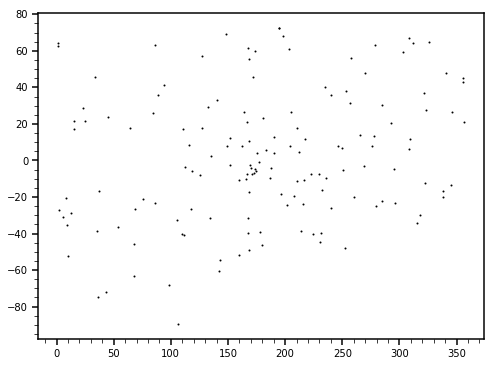

In [290]:

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/GCs_cartesian_galactocentric.txt',skip_header=1)


x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

#tl,tb,td,tvr,tdml,tdmb = jorge_galactic(x,y,z,vx,vy,vz)


l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]

plt.scatter(l,b,color='black',s=1.)




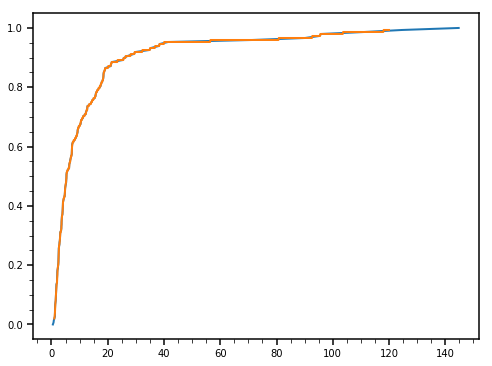

In [276]:
# read in the GCs for masking

#RAJ2000;DEJ2000;GLON;GLAT;gmag;u-g;D0.2;fm;cHg;bHg;d;r;x;y;z;HRV;e_HRV;Vgal;DR8;Sloan;SimbadName



# interpolate the distance function to select mock stars

distsort = np.argsort(d)
plt.plot(d[distsort],np.linspace(0.,1.,d.size))

f=open('gcrange.txt','w')
for indx in range(d.size): print(d[distsort][indx],np.linspace(0.,1.,d.size)[indx],file=f)
f.close()
    
    
# invert to interpolate
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

#spl = UnivariateSpline(V19['dist'][distsort],np.linspace(0.,1.,V19['dist'].size),k=4,s=1)
spl = interp1d(d[distsort],np.linspace(0.,1.,d.size),'nearest')
tstdist = np.linspace(1.,120.,1000)
plt.plot(tstdist,spl(tstdist))



[154.76597003 174.65702011 189.96337356 ... 252.07222623 252.1967233
 253.18843218]


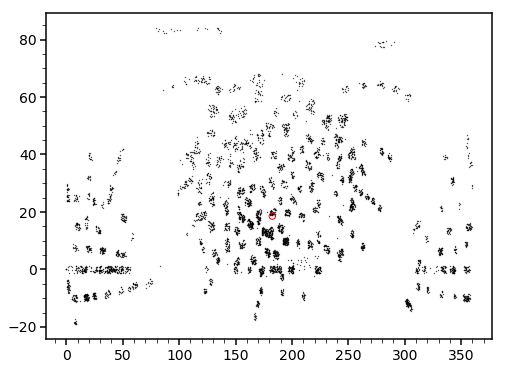

In [10]:
#print(V19['Name'])
print(gaiadict['gra'])
plt.scatter(gaiadict['gra'],gaiadict['gdec'],s=0.1,color='black')
plt.scatter(V19['ra'][20],V19['dec'][20],edgecolor='red',facecolor='none',s=40.)

In [11]:
# measure the distance of each star to each GC center

def spatial_distance(ra1,ra2,dec1,dec2):
    """compute a simple spherical onsky distance"""
    
    deltara  = 15.*np.cos(dec1)*np.abs(ra1-ra2)
    deltadec = np.abs(dec1-dec2)
    
    return np.sqrt(deltara*deltara + deltadec*deltadec)
    
    

for igc,gc in enumerate(V19['Name']):
    #if igc != 20: continue
    print(gc,V19['ra'][igc],V19['dec'][igc])
    
    dist = spatial_distance(gaiadict['gra'],V19['ra'][igc],gaiadict['gdec'],V19['dec'][igc])
    
    #sortedlist = dist.argsort()
    #for i in range(0,10):
    #    print(gaiadict['gra'][sortedlist[i]],V19['ra'][igc],gaiadict['gdec'][sortedlist[i]],V19['dec'][igc])
    
    #print(np.nanmin(dist))
    print(np.where(dist<10./60.))
    
    #print(dist[dist.argsort()][0:10])
    
    #plt.plot(dist[dist.argsort()])
    


b'NGC 104    ' 6.024 -72.081
(array([], dtype=int64),)
b'NGC 288    ' 13.188 -26.583
(array([], dtype=int64),)
b'NGC 362    ' 15.809 -70.849
(array([], dtype=int64),)
b'Whiting 1  ' 30.738 -3.253
(array([], dtype=int64),)
b'NGC 1261   ' 48.068 -55.216
(array([], dtype=int64),)
b'Pal 1      ' 53.334 79.581
(array([], dtype=int64),)
b'E 1        ' 58.76 -49.615
(array([], dtype=int64),)
b'Eridanus   ' 66.185 -21.187
(array([], dtype=int64),)
b'Pal 2      ' 71.525 31.381
(array([], dtype=int64),)
b'NGC 1851   ' 78.528 -40.047
(array([], dtype=int64),)
b'NGC 1904   ' 81.046 -24.525
(array([], dtype=int64),)
b'NGC 2298   ' 102.248 -36.005
(array([], dtype=int64),)
b'NGC 2419   ' 114.535 38.882
(array([], dtype=int64),)
b'Pyxis      ' 136.991 -37.221
(array([], dtype=int64),)
b'NGC 2808   ' 138.013 -64.864
(array([], dtype=int64),)
b'E 3        ' 140.238 -77.282
(array([], dtype=int64),)
b'Pal 3      ' 151.383 0.072
(array([], dtype=int64),)
b'NGC 3201   ' 154.403 -46.412
(array([], dtype=in

In [294]:
keep[1000]

1001

In [102]:


# set the coordinates for transformation

# use the schonrich 2010 peculiar motions
usun = 11.1
vsun = 12.24
wsun = 7.25

# use the circular velocity from ...
vcirc = 235.

# the value of mcmillan 2017
vcirc = 220.
#vcirc = 244.
#vcirc = 232.

# use the gravity 2018 result for the galactic center distance
rsun = 8.3 # in kpc

# use the sun's height above the midplane from Bovy...
zsun = 20 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)


class dataset(object):
    '''placeholder for all the quantities we want
    '''
    ra = None
    dec = None
    l = None
    b = None
    d = None
    x = None
    y = None
    z = None
    vx = None
    vy = None
    vz = None
    r = None
    th = None
    ph = None
    vr = None
    vth = None
    vph = None
    pmra = None
    pmdec = None
    epmra = None
    epmdec = None
    vrad = None
    evrad = None
    feh = None
    gflux = None

    
class newcoordinates():
    """take a system with
    
    ra,dec,ra_error,dec_error,pmra,pmdec,pmra_error,pmdec_error,dist,dist_error
    
    """
    
    def __init__(self,inputcatalog,errors=False):
        """take input catalog and make homogenous system
        
        how do we treat missing data in this framework?
        
        """
        
        self.ra       = inputcatalog['ra']
        self.dec      = inputcatalog['dec']
        self.d        = inputcatalog['d']
        self.pmra     = inputcatalog['pmra']
        self.pmdec    = inputcatalog['pmdec']
        self.vrad     = inputcatalog['vrad']

    
        if errors:
            self.raerr    = inputcatalog['raerr']
            self.decerr   = inputcatalog['decerr']
            self.derr     = inputcatalog['derr']        
            self.pmraerr  = inputcatalog['pmraerr']        
            self.pmdecerr = inputcatalog['pmdecerr']        
            self.vraderr  = inputcatalog['vraderr']
        
        
    def find_covariances(self):
        """look at the errors and find real estimates for errors based on the covariances
        
        -should we brute force the errors as a monte carlo?
        
        """
        
        cplus = coord.SkyCoord(ra  = self.ra    + self.raerr    * u.deg,\
                   dec             = self.dec   + self.decerr   * u.deg,\
                   distance        = self.d     + self.derr     * u.kpc,\
                   pm_ra_cosdec    = self.pmra  + self.pmraerr  * u.mas/u.yr,\
                   pm_dec          = self.pmdec + self.pmdecerr * u.mas/u.yr,\
                   radial_velocity = self.vrad  + self.vraderr  * u.km/u.s)
        


    def gc_transform(self):
        '''define a galactic transform
        
        '''
        
        c = coord.SkyCoord(ra      = self.ra    * u.deg,\
                   dec             = self.dec   * u.deg,\
                   distance        = self.d     * u.kpc,\
                   pm_ra_cosdec    = self.pmra  * u.mas/u.yr,\
                   pm_dec          = self.pmdec * u.mas/u.yr,\
                   radial_velocity = self.vrad  * u.km/u.s)
        

        gal_defined = c.transform_to(gc_frame)
        gal_latlon  = c.transform_to('galactic')
        
        self.x = gal_defined.x
        self.y = gal_defined.y
        self.z = gal_defined.z
        
        #print(gal_defined.l)
        
        self.vx = gal_defined.v_x
        self.vy = gal_defined.v_y
        self.vz = gal_defined.v_z

        # do a transform of l to the correct orientation?
        tmpl = gal_latlon.l
        
        self.l = np.array(tmpl)

        #self.l[self.l>180.] -= 360.
        #self.l *= -1.
        
        
        
        self.b = np.array(gal_latlon.b)
        
        # be careful about the cos(b) term included here...
        self.vl = np.array(gal_latlon.pm_l_cosb)
        self.vb = np.array(gal_latlon.pm_b)
        
        self.gdist = np.array(gal_latlon.distance)
        self.gsr = np.array(gal_latlon.radial_velocity)

    def sph_transform(self):
        """convert cartesian to spherical
        """
        self.rho = np.sqrt(self.x*self.x + self.y*self.y + self.z*self.z)
        self.r = np.sqrt(self.x*self.x + self.y*self.y)
        self.phi = np.arctan2(self.y,self.x)
        self.theta = np.arccos(self.z/self.r)

        self.vr = (self.x*self.vx + self.y*self.vy + self.z*self.vz)/self.rho
        self.vphi = (self.vx*self.y - self.x*self.vy)/(self.r*self.r)
        self.vtheta = ( self.z*(self.x*self.vx + self.y*self.vy) \
                     - self.r*self.r*self.vz )/(self.rho*self.rho*self.r)   
        
        
    

    

In [103]:

def find_errors(X14,gaiadict,keep,indx,nsamples=10000,verbose=False,sgr=False):
    ra = X14['RA'][keep[indx]]
    dec = X14['Dec'][keep[indx]]
    d = X14['d'][keep[indx]]
    derr = X14['ed'][keep[indx]]
    pmra = gaiadict['gpmra'][keep[indx]]
    pmraerr = gaiadict['gpmra_error'][keep[indx]]
    pmdec = gaiadict['gpmdec'][keep[indx]]
    pmdecerr = gaiadict['gpmdec_error'][keep[indx]]
    vrad = X14['HRV'][keep[indx]]
    vraderr = X14['eHRV'][keep[indx]]

    cplus = coord.SkyCoord(ra              = np.tile(ra,nsamples)                                 * u.deg,\
                           dec             = np.tile(dec,nsamples)                                 * u.deg,\
                           distance        = np.nanmax([np.zeros(nsamples)+.1,(d     + np.random.normal(size=nsamples)*derr)],axis=0)     * u.kpc,\
                           pm_ra_cosdec    = (pmra  + np.random.normal(size=nsamples)*pmraerr)  * u.mas/u.yr,\
                           pm_dec          = (pmdec + np.random.normal(size=nsamples)*pmdecerr) * u.mas/u.yr,\
                           radial_velocity = (vrad  + np.random.normal(size=nsamples)*vraderr)  * u.km/u.s)

    cbest = coord.SkyCoord(ra              = ra    * u.deg,\
                           dec             = dec   * u.deg,\
                           distance        = d     * u.kpc,\
                           pm_ra_cosdec    = pmra  * u.mas/u.yr,\
                           pm_dec          = pmdec * u.mas/u.yr,\
                           radial_velocity = vrad  * u.km/u.s)

    if verbose:
        print(pmra,pmdec,vrad)

    gal_latlon  = cplus.transform_to('galactic')
    gal_defined = cplus.transform_to(gc_frame)
        
    best_latlon  = cbest.transform_to('galactic')
    best_defined = cbest.transform_to(gc_frame)
    
    if sgr:
        best_sgr = cbest.transform_to(Sagittarius)
        return gal_latlon,gal_defined,best_latlon,best_defined,best_sgr
    
    else:
        return gal_latlon,gal_defined,best_latlon,best_defined



    
    return gal_latlon,gal_defined,best_latlon,best_defined


indx = 40
gal_latlon,gal_defined,best_latlon,best_defined = find_errors(X14,gaiadict,keep,indx,nsamples=1000,verbose=True)

gal_latlon,gal_defined,best_latlon,best_defined,best_sgr = find_errors(X14,gaiadict,keep,indx,nsamples=1000,verbose=True,sgr=True)




-1.252004765530831 -4.376908488769173 -275.2
-1.252004765530831 -4.376908488769173 -275.2


In [104]:

indx = 40
gal_latlon,gal_defined,best_latlon,best_defined = find_errors(X14,gaiadict,keep,indx,nsamples=1000,verbose=False)




sol_pos = [-8.3,0.,0.03]
sol_vel = [11.1,244.24,7.25]
dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x)-sol_pos[0],\
                                                      np.array(best_defined.y)-sol_pos[1],\
                                                      np.array(best_defined.z)-sol_pos[2],\
                                                      np.array(best_defined.v_x)-sol_vel[0],\
                                                      np.array(best_defined.v_y)-sol_vel[1],\
                                                      np.array(best_defined.v_z)-sol_vel[2])

print(dLj,dBj,radj)
print(np.array(best_latlon.l),np.array(best_latlon.b),np.array(best_latlon.distance))
print('-------------------------------')
print(vrj,dmulj,dmubj)
print(np.array(best_latlon.radial_velocity),np.array(best_latlon.pm_l_cosb),np.array(best_latlon.pm_b))

40.13484391150348 -28.09534498812332 13.794722837604322
40.087656844247654 -27.95325575855668 13.790000000000001
-------------------------------
[-281.98567545] [-4.60155068] [-0.95672294]
-275.2 -4.464448790458659 -0.8908090981482948


In [298]:
# this results in various errors...
print(np.percentile(gal_defined.x,20.),np.percentile(gal_defined.x,50.),np.percentile(gal_defined.x,80.))

print(np.percentile(gal_latlon.distance,20.),np.percentile(gal_latlon.distance,50.),np.percentile(gal_latlon.distance,80.))


dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(gal_defined.x),\
                                                  np.array(gal_defined.y),\
                                                  np.array(gal_defined.z),\
                                                  np.array(gal_defined.v_x),\
                                                  np.array(gal_defined.v_y),\
                                                  np.array(gal_defined.v_z))


print(np.percentile(dLj,50.),np.percentile(dBj,50.))
print(X15['Glon'][keep[indx]],X15['Glat'][keep[indx]])

-0.371228013728506 0.9435846426316363 2.329485494976836
11.7618730300842 13.712334627100226 15.768252157780482
83.10227992002396 -39.149303005537135
40.087648 -27.953253


In [26]:
keep.size,gaiadict['gpmra'][keep].size

(6032, 6032)

In [39]:
dist = np.zeros(keep.size)
for indx,i in enumerate(keep):
    #print(indx)

    gal_latlon,gal_defined,best_latlon,best_defined = find_errors(X14,gaiadict,keep,indx,nsamples=1,sgr=False)

    dist[indx] = np.array(np.sqrt(best_defined.x*best_defined.x + best_defined.y*best_defined.y + best_defined.z*best_defined.z))



20


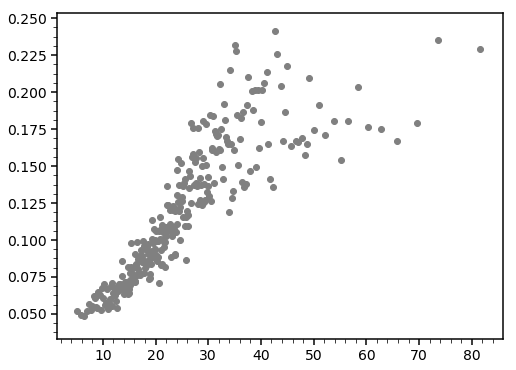

In [60]:
distsort = dist.argsort()
dvals = dist[distsort]

#plt.scatter(dvals,np.abs(uni_noise[distsort]/uni_signal[distsort]),color='black',s=0.1)

signoise = np.abs(gaiadict['gpmra_error'])#/gaiadict['gpmra'])[keep]
signoise = np.abs(gaiadict['gpmdec_error'])[keep]#/gaiadict['gpmdec'])[keep]
#signoise3 = np.sqrt((gaiadict['gpmdec_error']/gaiadict['gpmdec'])*(gaiadict['gpmdec_error']/gaiadict['gpmdec']) +\
#                    (gaiadict['gpmra_error']/gaiadict['gpmra'])*(gaiadict['gpmra_error']/gaiadict['gpmra']))[keep]

dbins = 300
nperbin = int(dvals.size/dbins)
print(nperbin)

f = open('kgiantsignnoise.txt','w')
for b in range(0,dbins):
    plt.scatter(np.nanmedian(dist[distsort[b*nperbin:(b+1)*nperbin]]),\
                np.nanmedian(signoise[distsort[b*nperbin:(b+1)*nperbin]]),\
               color='gray')   
    print(np.nanmedian(dist[distsort[b*nperbin:(b+1)*nperbin]]),
          np.nanmedian(signoise[distsort[b*nperbin:(b+1)*nperbin]]),file=f)
    
f.close()

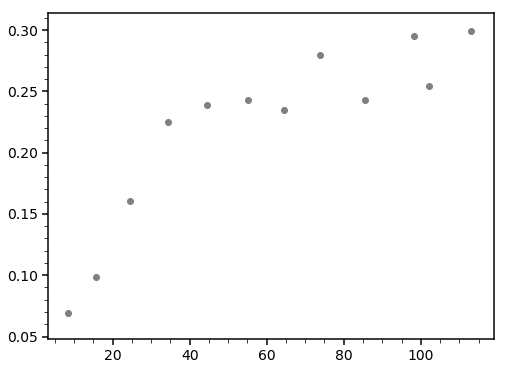

In [63]:
signoise = np.sqrt(gaiadict['gpmdec_error']*gaiadict['gpmdec_error'] +\
                   np.cos(gaiadict['gdec'])*np.cos(gaiadict['gdec'])*gaiadict['gpmra_error']*gaiadict['gpmra_error'])[keep]



dbins = 12

binvals = np.linspace(0.,111.,dbins)


f = open('kgiantsignnoise.txt','w')
for b in range(0,dbins):
    if b==dbins-1:
        maxval = np.inf
    else:
        maxval = binvals[b+1]
    w = np.where((dist>binvals[b])&(dist<maxval))
    plt.scatter(np.nanmedian(dist[w]),\
                np.nanmedian(signoise[w]),\
               color='gray')   
    print(np.nanmedian(dist[w]),
          np.nanmedian(signoise[w]),file=f)
    
f.close()

In [299]:
np.percentile(gal_defined.v_x,50.)

-8.47375751268684

In [105]:


f = open('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_galactocentric_sgr_v220.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     phi1 [deg]; phi2 [deg]; radius [kpc]; vgsr [km/s]; dmuphi1 [marcsec/yr]; dmuphi2 [marcsec/yr]; \
      eradius[kpc]; evgsr [km/s]; edmuphi1 [marcsec/yr]; edmuphi2 [marcsec/yr];\
      sgrweak [bool]; sgrstrong [bool]; FeH [dex]; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]',file=f)


g = open('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr_v220.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr]; \
      edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];\
      sgrweak [bool]; sgrstrong [bool]; FeH [dex]; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]',file=g)




for indx,i in enumerate(keep):
    #print(indx)

    gal_latlon,gal_defined,best_latlon,best_defined,best_sgr = find_errors(X14,gaiadict,keep,indx,nsamples=1000,sgr=True)

    dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x),\
                                                  np.array(best_defined.y),\
                                                  np.array(best_defined.z),\
                                                  np.array(best_defined.v_x),\
                                                  np.array(best_defined.v_y),\
                                                  np.array(best_defined.v_z))

    edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x),\
                                                  np.array(gal_defined.y),\
                                                  np.array(gal_defined.z),\
                                                  np.array(gal_defined.v_x),\
                                                  np.array(gal_defined.v_y),\
                                                  np.array(gal_defined.v_z))
   

    if np.isfinite(np.array(best_defined.v_x)):
        print(np.round(np.array(best_defined.x),2),\
              np.round(np.array(best_defined.y),2),\
              np.round(np.array(best_defined.z),2),\
              np.round(np.array(best_defined.v_x),2),\
              np.round(np.array(best_defined.v_y),2),\
              np.round(np.array(best_defined.v_z),2),\
            np.round(dLj,2),\
              np.round(dBj,2),\
              np.round(radj,2),\
              np.round(vrj[0],2),\
              np.round(dmulj[0],4),\
              np.round(dmubj[0],4),\
            np.round(np.abs(np.percentile(eradj,86)-np.percentile(eradj,50)),2),\
              np.round(np.abs(np.percentile(evrj,86)-np.percentile(evrj,50)),2),\
              np.round(np.abs(np.percentile(edmulj,86)-np.percentile(edmulj,50)),4),\
              np.round(np.abs(np.percentile(edmubj,86)-np.percentile(edmubj,50)),4),
              int(sgrweak[indx]),\
              int(sgrstrong[indx]),\
              np.round(X14['FeH'][keep[indx]],3),\
              np.round(np.array(best_sgr.Lambda),2),\
              np.round(np.array(best_sgr.Beta),2),\
              int(sgrbelo[indx]),\
            file=f)

        # redo with transpose to heliocentric...
        sol_pos = [-8.3,0.,0.03]
        sol_vel = [11.1,244.24-12,7.25]

        dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x)-sol_pos[0],\
                                                      np.array(best_defined.y)-sol_pos[1],\
                                                      np.array(best_defined.z)-sol_pos[2],\
                                                      np.array(best_defined.v_x)-sol_vel[0],\
                                                      np.array(best_defined.v_y)-sol_vel[1],\
                                                      np.array(best_defined.v_z)-sol_vel[2])

        edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x)-sol_pos[0],\
                                                            np.array(gal_defined.y)-sol_pos[1],\
                                                            np.array(gal_defined.z)-sol_pos[2],\
                                                            np.array(gal_defined.v_x)-sol_vel[0],\
                                                            np.array(gal_defined.v_y)-sol_vel[1],\
                                                            np.array(gal_defined.v_z)-sol_vel[2])    

        print(np.round(np.array(best_defined.x),2),\
              np.round(np.array(best_defined.y),2),\
              np.round(np.array(best_defined.z),2),\
              np.round(np.array(best_defined.v_x),2),\
              np.round(np.array(best_defined.v_y),2),\
              np.round(np.array(best_defined.v_z),2),\
            np.round(dLj,2),\
              np.round(dBj,2),\
              np.round(radj,2),\
              np.round(vrj[0],2),\
              np.round(dmulj[0],4),\
              np.round(dmubj[0],4),\
            np.round(np.abs(np.percentile(eradj,86)-np.percentile(eradj,50)),2),\
              np.round(np.abs(np.percentile(evrj,86)-np.percentile(evrj,50)),2),\
              np.round(np.abs(np.percentile(edmulj,86)-np.percentile(edmulj,50)),4),\
              np.round(np.abs(np.percentile(edmubj,86)-np.percentile(edmubj,50)),4),\
              int(sgrweak[indx]),\
              int(sgrstrong[indx]),\
              np.round(X14['FeH'][keep[indx]],3),\
              np.round(np.array(best_sgr.Lambda),2),\
              np.round(np.array(best_sgr.Beta),2),\
              int(sgrbelo[indx]),\
              file=g)


f.close()
g.close()












IndexError: index 6016 is out of bounds for axis 0 with size 6016

In [301]:


f = open('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_galactocentric_II.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     phi1 [deg]; phi2 [deg]; radius [kpc]; vgsr [km/s]; dmuphi1 [marcsec/yr]; dmuphi2 [marcsec/yr]; \
      eradius[kpc]; evgsr [km/s]; edmuphi1 [marcsec/yr]; edmuphi2 [marcsec/yr];\
      sgrweak [bool]; sgrstrong [bool]; FeH [dex];',file=f)


g = open('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_II.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr]; \
      edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];\
      sgrweak [bool]; sgrstrong [bool]; FeH [dex]',file=g)




for indx,i in enumerate(keep):
    #print(indx)

    gal_latlon,gal_defined,best_latlon,best_defined = find_errors(X14,gaiadict,keep,indx,nsamples=1000)

    dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x),\
                                                  np.array(best_defined.y),\
                                                  np.array(best_defined.z),\
                                                  np.array(best_defined.v_x),\
                                                  np.array(best_defined.v_y),\
                                                  np.array(best_defined.v_z))

    edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x),\
                                                  np.array(gal_defined.y),\
                                                  np.array(gal_defined.z),\
                                                  np.array(gal_defined.v_x),\
                                                  np.array(gal_defined.v_y),\
                                                  np.array(gal_defined.v_z))
   

    if np.isfinite(np.array(best_defined.v_x)):
        print(np.round(np.array(best_defined.x),2),\
              np.round(np.array(best_defined.y),2),\
              np.round(np.array(best_defined.z),2),\
              np.round(np.array(best_defined.v_x),2),\
              np.round(np.array(best_defined.v_y),2),\
              np.round(np.array(best_defined.v_z),2),\
            np.round(dLj,2),\
              np.round(dBj,2),\
              np.round(radj,2),\
              np.round(vrj[0],2),\
              np.round(dmulj[0],4),\
              np.round(dmubj[0],4),\
            np.round(np.abs(np.percentile(eradj,86)-np.percentile(eradj,50)),2),\
              np.round(np.abs(np.percentile(evrj,86)-np.percentile(evrj,50)),2),\
              np.round(np.abs(np.percentile(edmulj,86)-np.percentile(edmulj,50)),4),\
              np.round(np.abs(np.percentile(edmubj,86)-np.percentile(edmubj,50)),4),
              int(sgrweak[indx]),\
              int(sgrstrong[indx]),\
              np.round(X14['FeH'][keep[indx]],3),\
            file=f)

        # redo with transpose to heliocentric...
        sol_pos = [-8.3,0.,0.03]
        sol_vel = [11.1,244.24,7.25]

        dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x)-sol_pos[0],\
                                                      np.array(best_defined.y)-sol_pos[1],\
                                                      np.array(best_defined.z)-sol_pos[2],\
                                                      np.array(best_defined.v_x)-sol_vel[0],\
                                                      np.array(best_defined.v_y)-sol_vel[1],\
                                                      np.array(best_defined.v_z)-sol_vel[2])

        edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x)-sol_pos[0],\
                                                            np.array(gal_defined.y)-sol_pos[1],\
                                                            np.array(gal_defined.z)-sol_pos[2],\
                                                            np.array(gal_defined.v_x)-sol_vel[0],\
                                                            np.array(gal_defined.v_y)-sol_vel[1],\
                                                            np.array(gal_defined.v_z)-sol_vel[2])    

        print(np.round(np.array(best_defined.x),2),\
              np.round(np.array(best_defined.y),2),\
              np.round(np.array(best_defined.z),2),\
              np.round(np.array(best_defined.v_x),2),\
              np.round(np.array(best_defined.v_y),2),\
              np.round(np.array(best_defined.v_z),2),\
            np.round(dLj,2),\
              np.round(dBj,2),\
              np.round(radj,2),\
              np.round(vrj[0],2),\
              np.round(dmulj[0],4),\
              np.round(dmubj[0],4),\
            np.round(np.abs(np.percentile(eradj,86)-np.percentile(eradj,50)),2),\
              np.round(np.abs(np.percentile(evrj,86)-np.percentile(evrj,50)),2),\
              np.round(np.abs(np.percentile(edmulj,86)-np.percentile(edmulj,50)),4),\
              np.round(np.abs(np.percentile(edmubj,86)-np.percentile(edmubj,50)),4),\
              int(sgrweak[indx]),\
              int(sgrstrong[indx]),\
              np.round(X14['FeH'][keep[indx]],3),\
              file=g)


f.close()
g.close()











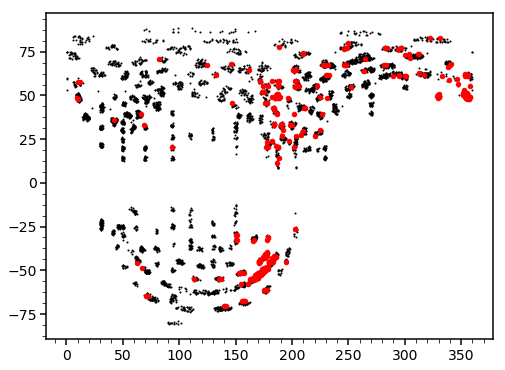

In [106]:
#In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_galactocentric_II.txt',skip_header=1)

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr.txt',skip_header=1)



x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

#tl,tb,td,tvr,tdml,tdmb = jorge_galactic(x,y,z,vx,vy,vz)


l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]

sgrweak = In[:,16]
sgrstrong = In[:,17]
feh = In[:,18]

plt.scatter(l,b,color='black',s=1.)
plt.scatter(l[sgrstrong==1],b[sgrstrong==1],color='red',s=20.)

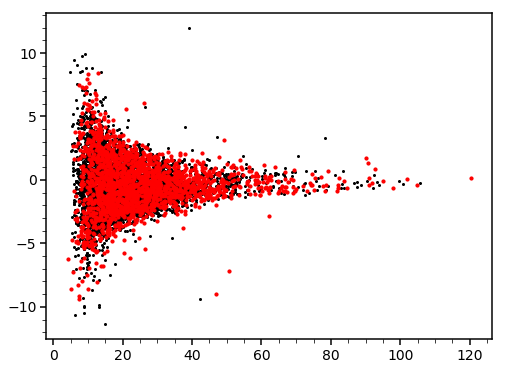

In [75]:
terror = np.sqrt(edml*edml + edmb*edmb)
terror = dmb

plt.scatter(d,terror,color='black',s=4.)
plt.scatter(d[feh<-1.8],terror[feh<-1.8],color='red',s=10.)




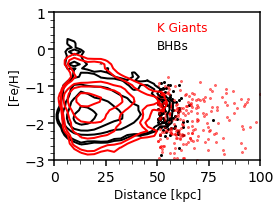

In [99]:
plt.figure(figsize=(4,3))

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr.txt',skip_header=1)
dbhb    = In[:,8]
fehbhb = In[:,18]

xx,yy,bhbw = kde_3d.total_kde_two(dbhb,fehbhb,\
                                       gridsize=32,\
                                       extents=(0.,100.,-3.,0.5),\
                                       ktype='gaussian',npower=5.)


plt.scatter(dbhb[dbhb>50.],fehbhb[dbhb>50.],color='black',s=4.)
plt.contour(xx,yy,np.flipud(bhbw),np.percentile(bhbw,[75.,80.,90.,95.,99.]),colors='black')



In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr.txt',skip_header=1)
dk    = In[:,8]
fehk = In[:,18]

#plt.scatter(dk,fehk,color='red',s=1.)

xx,yy,kw = kde_3d.total_kde_two(dk,fehk,\
                                       gridsize=32,\
                                       extents=(0.,100.,-3.,0.5),\
                                       ktype='gaussian',npower=5.)


plt.scatter(dk[dk>50.],fehk[dk>50.],color='red',s=4.,alpha=0.5)
plt.contour(xx,yy,np.flipud(kw),np.percentile(kw,[75.,80.,90.,95.,99.]),colors='red')




plt.axis([0.,100.,-3.,1.])

plt.text(50.,0.5,'K Giants',color='red',size=12)
plt.text(50.,0.0,'BHBs',color='black',size=12)


plt.xlabel('Distance [kpc]',size=12)
plt.ylabel('[Fe/H]',size=12)

plt.tight_layout()

plt.savefig('/Users/mpetersen/Downloads/metalcomp.png',dpi=300)

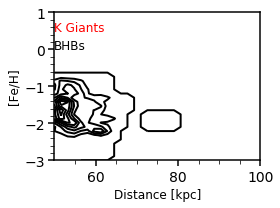

In [95]:
plt.figure(figsize=(4,3))

In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/BHBs_cartesian_heliocentric_sgr.txt',skip_header=1)
dbhb    = In[:,8]
fehbhb = In[:,18]

xx,yy,bhbw = kde_3d.total_kde_two(dbhb,fehbhb,\
                                       gridsize=32,\
                                       extents=(50.,100.,-3.,0.5),\
                                       ktype='gaussian',npower=6.)


#plt.scatter(dbhb,fehbhb,color='black',s=1.)
plt.contour(xx,yy,np.flipud(bhbw),8,colors='black')#np.percentile(bhbw,[75.,80.,90.,95.,99.]),colors='black')



In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_heliocentric_sgr.txt',skip_header=1)
dk    = In[:,8]
fehk = In[:,18]

#plt.scatter(dk,fehk,color='red',s=1.)

xx,yy,kw = kde_3d.total_kde_two(dk,fehk,\
                                       gridsize=32,\
                                       extents=(50.,100.,-3.,0.5),\
                                       ktype='gaussian',npower=5.)


#plt.scatter(dk,fehk,color='black',s=1.)
#plt.contour(xx,yy,np.flipud(kw),np.percentile(kw,[75.,80.,90.,95.,99.]),colors='red')




plt.axis([50.,100.,-3.,1.])

plt.text(50.,0.5,'K Giants',color='red',size=12)
plt.text(50.,0.0,'BHBs',color='black',size=12)


plt.xlabel('Distance [kpc]',size=12)
plt.ylabel('[Fe/H]',size=12)

plt.tight_layout()

plt.savefig('/Users/mpetersen/Downloads/metalcomp50.png',dpi=300)

0.00025395218126540286


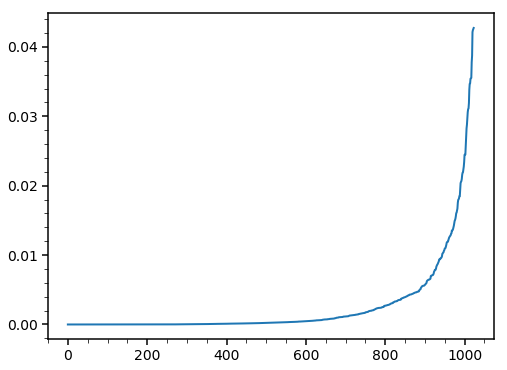

In [87]:
kwf = kw.reshape(-1,)
plt.plot(kwf[kwf.argsort()])

print(np.percentile(kw,50.))

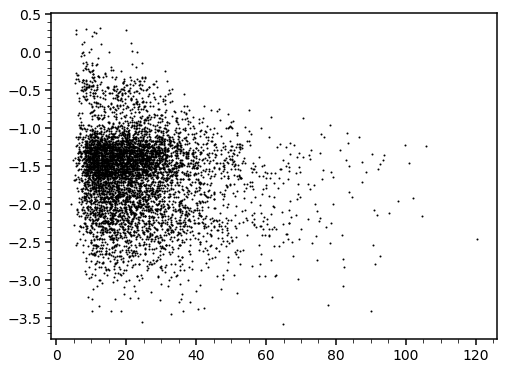

In [64]:
plt.scatter(d,feh,color='black',s=1.)

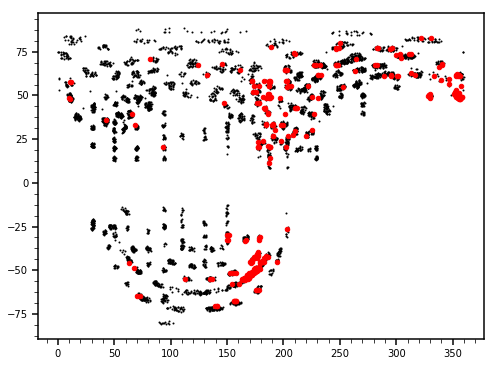

In [303]:
plt.scatter(l,b,color='black',s=1.)
plt.scatter(l[sgrstrong==1],b[sgrstrong==1],color='red',s=20.)

In [228]:
print(l.size)

6016


In [37]:
gal_latlon

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    [(226.61229904, 37.10947465, 12.81906714),
     (226.61229904, 37.10947465, 13.07379271),
     (226.61229904, 37.10947465, 13.29348591), ...,
     (226.61229904, 37.10947465, 13.23605926),
     (226.61229904, 37.10947465, 12.06157287),
     (226.61229904, 37.10947465, 12.31209413)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(2.42585599, -2.2739829 , 210.67647321),
     (2.05115629, -2.14580753, 224.81133993),
     (2.56375207, -2.43397706, 245.33278309), ...,
     (2.30899942, -2.55109883, 216.30768767),
     (2.67481618, -2.37703855, 223.45810628),
     (2.86231511, -2.19814048, 202.37279063)]>

In [38]:
import reflexmotion as rm

65.50115829538291 75.28516390898376 84.73826310472847
5.457131428764043 20.032157304383766 35.23170997223318


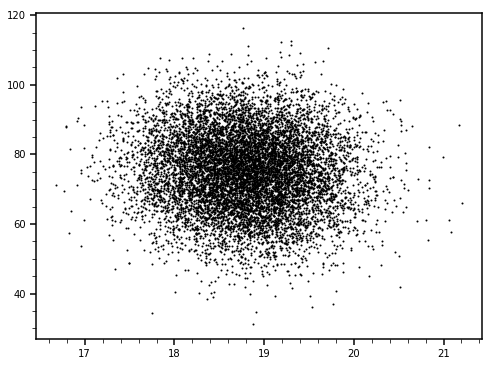

In [39]:
#plt.scatter(gal_latlon.pm_l_cosb,gal_latlon.pm_b,color='black',s=1.)

dist,b,l,vlos,vtheta,vphi = rm.compute_spherical(np.array(gal_defined.x),np.array(gal_defined.y),np.array(gal_defined.z),\
                                                np.array(gal_defined.v_x),np.array(gal_defined.v_y),np.array(gal_defined.v_z))



#plt.scatter(gal_defined.x,gal_defined.v_x,color='black',s=1.)
#plt.scatter(gal_defined.y,gal_defined.v_y,color='red',s=1.)
#plt.scatter(gal_defined.z,gal_defined.v_z,color='blue',s=1.)

#plt.scatter(180.*l/np.pi,180.*b/np.pi,color='black',s=1.)
#plt.axis([0,360,-90,90])

plt.scatter(dist,vlos,color='black',s=1.)

print(np.percentile(vlos,20.),np.percentile(vlos,50.),np.percentile(vlos,80.))
print(np.percentile(vphi,20.),np.percentile(vphi,50.),np.percentile(vphi,80.))




### Really need to flag GCs. You have the list, just do it already!

In [90]:
kcat = {}
kcat['ra'] = X15['RA'][keep]
kcat['dec'] = X15['Dec'][keep]
kcat['d'] = X15['d'][keep]
kcat['pmra'] = gaiadict['gpmra'][keep]#*np.cos(X11['Dec'][keep]* np.pi / 180.)
kcat['pmdec'] = gaiadict['gpmdec'][keep]
kcat['vrad'] = X15['HRV'][keep]
kcat['feh'] = X15['FeH'][keep]


In [91]:
KGiant = newcoordinates(kcat)

KGiant.gc_transform()
KGiant.sph_transform()

In [42]:

f = open('/Users/mpetersen/Downloads/KGiant_latlon.txt','w')

for indx in range(0,KGiant.l.size):
    print(KGiant.l[indx],KGiant.b[indx],KGiant.gdist[indx],KGiant.vl[indx],KGiant.vb[indx],KGiant.gsr[indx],file=f)

    
f.close()

In [43]:
In = np.genfromtxt('/Users/mpetersen/Downloads/KGiant_latlon.txt')

al = In[:,0]
ab = In[:,1]
ad = In[:,2]
avl = In[:,3]
avb = In[:,4]
avr = In[:,5]

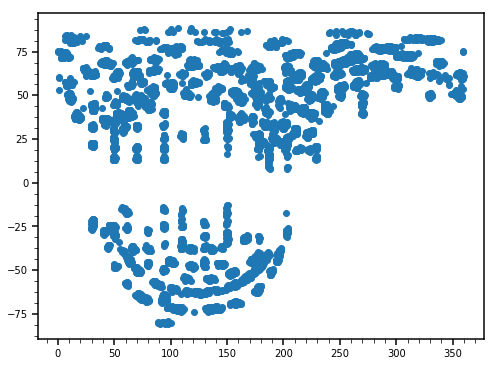

In [44]:
plt.scatter(KGiant.l,KGiant.b)

In [92]:
# print to a file...

# with a flipped vb ONLY?


def jorge_galactic(x0,y0,z0,u0,v0,w0):
    
    rad = np.sqrt(x0**2+y0**2+z0**2)
    xphi= np.arctan2(y0,x0)
    xth = np.arccos(z0/rad)
    
    xur = np.zeros([3,x0.size])
    xur[0]= np.sin(xth)*np.cos(xphi)
    xur[1]= np.sin(xth)*np.sin(xphi)
    xur[2]= np.cos(xth)
         
    xuth = np.zeros([3,x0.size])
    xuth[0]= np.cos(xth)*np.cos(xphi)
    xuth[1]= np.cos(xth)*np.sin(xphi)
    xuth[2]=-np.sin(xth)

    xuphi = np.zeros([3,x0.size])
    xuphi[0]=-np.sin(xphi)
    xuphi[1]=+np.cos(xphi)
    xuphi[2]= 0.
    
    vr =    u0*  xur[0] + v0*  xur[1] + w0*  xur[2]
    vth=    u0* xuth[0] + v0* xuth[1] + w0* xuth[2]
    vphi=   u0*xuphi[0] + v0*xuphi[1] + w0*xuphi[2]
          
    vb= -vth
    
    # following the astropy convention
    vl= vphi
         
    dk  =4.74057           #conversion from km/s
    par =1./rad             #arc sec --> rad in [kpc]
    dmul=vl / dk * par
    dmub=vb / dk * par

    f=np.pi/180.
    dB=np.arcsin(z0/rad)/f
    #dL=np.arctan(y0/x0)/f
    
    #dL[(y0<0)&(x0>0.)] += 360.
    #dL[(y0>0)&(x0<0.)] += 180.
    #dL[(y0<0)&(x0<0.)] += 180.
    
    dL = np.arctan2(y0,x0)/f
    
    #print(dL)
    
    if dL.size>1:
        dL[np.array(dL)<0.] += 360.
    else:
        if dL<0.: dL+=360.
    #if ((y0<0)&(x0>0.)): dL=dL+360.
    #if ((y0>0)&(x0<0.)): dL=dL+180.
    #if ((y0<0)&(x0<0.)): dL=dL+180.
    
    return dL,dB,rad,vr,dmul,dmub




dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(KGiant.x),np.array(KGiant.y),np.array(KGiant.z),\
                               np.array(KGiant.vx),np.array(KGiant.vy),np.array(KGiant.vz))











In [291]:
# interpolate the distance function to select mock stars

distsort = np.argsort(radj)
plt.plot(radj[distsort],np.linspace(0.,1.,radj.size))

f=open('kgiantrange.txt','w')
for indx in range(radj.size): print(radj[distsort][indx],np.linspace(0.,1.,radj.size)[indx],file=f)
f.close()
    
    
# invert to interpolate
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

spl = UnivariateSpline(radj[distsort],np.linspace(0.,1.,radj.size),k=4,s=1)
spl = interp1d(radj[distsort],np.linspace(0.,1.,radj.size),'nearest')
tstdist = np.linspace(5.,120.,1000)
plt.plot(tstdist,spl(tstdist))


IndexError: invalid index to scalar variable.

In [47]:
radj.size

6032

In [48]:
w = np.where(radj>60.)[0]
print(w.size)

145


In [52]:
In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiant_galactic_helio_sgr.txt',skip_header=1)

phi1      = In[:,0]
phi2      = In[:,1]
r         = In[:,2]
vphi1     = In[:,3]
vphi2     = In[:,4]
vgsr      = In[:,5]
l         = In[:,6]
b         = In[:,7]
d         = In[:,8]
mu_l      = In[:,9]
mu_b      = In[:,10]
vlos      = In[:,11]
sgrweak   = In[:,12]
sgrstring = In[:,13]

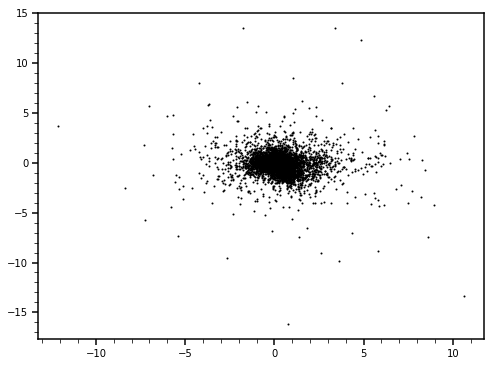

In [64]:
plt.scatter(vphi1,vphi2,color='black',s=1.)



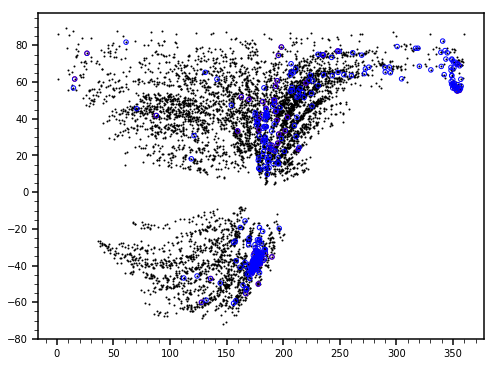

In [61]:
plt.scatter(phi1,phi2,color='black',s=1.)

plt.scatter(phi1[sgrweak==1],phi2[sgrweak==1],marker='o',edgecolor='red',s=20.,facecolor='none')
plt.scatter(phi1[sgrstrong==1],phi2[sgrstrong==1],marker='o',edgecolor='blue',s=20.,facecolor='none')

In [101]:

f = open('/Users/mpetersen/Dropbox/mike/data/KGiant_Xue_half2.txt','w')

"""
print('x [kpc]; y [kpc]; z [kpc]; \
       vx [km/s]; vy [km/s]; vz [km/s]; \
       l [deg]; b [deg]; d [kpc]; \
       mu_l [km/s]; mu_b [km/s]; vlos [km/s]; \
       rapo [kpc]; rperi [kpc]; zmax [kpc]; \
       Sgr Lambda [deg];Sgr Beta [deg]',file=f)
"""

print('x [kpc]; y [kpc]; z [kpc]; \
       vx [km/s]; vy [km/s]; vz [km/s]; \
       l [deg]; b [deg]; d [kpc]; \
       mu_l [km/s]; mu_b [km/s]; vlos [km/s]',file=f)



acc = 0
#for i in range(0,PSPDump.xpos.size):
for i in range(0,len(KGiant.x)):
    
    print(np.round(np.array(KGiant.x[i]),2),\
          np.round(np.array(KGiant.y[i]),2),\
          np.round(np.array(KGiant.z[i]),2),\
          np.round(np.array(KGiant.vx[i]),2),\
          np.round(np.array(KGiant.vy[i]),2),\
          np.round(np.array(KGiant.vz[i]),2),\
          np.round(np.array(dLj[i]),2),\
          np.round(np.array(dBj[i]),2),\
              np.round(np.array(radj[i]),2),\
              np.round(np.array(dmulj[i]),3),\
              np.round(np.array(dmubj[i]),3),\
              np.round(np.array(vrj[i]),2),\
#              np.round(rapo[i],2),\
#              np.round(rperi[i],2),\
#              np.round(zmax[i],2),\
#              np.round(np.array(sgr.Lambda[i]),2),\
#              np.round(np.array(sgr.Beta[i]),2),\
              file=f)

f.close()








In [15]:
Gmatch['ra']

array([331.04739862, 330.60694414, 330.92495452, ..., 191.67356168,
       191.2056253 , 147.16766211])

(0.0, 1.0)

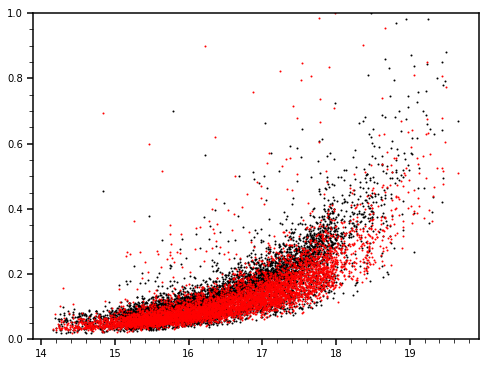

In [48]:
plt.scatter(Gmatch['phot_g_mean_mag'],Gmatch['pmra_error'],color='black',s=1.)
plt.scatter(Gmatch['phot_g_mean_mag'],Gmatch['pmdec_error'],color='red',s=1.)


#plt.axis([-1,1.,-1,1.])
plt.ylim([0.,1.])

[-3.5, 1.0, -3.5, 1.0]

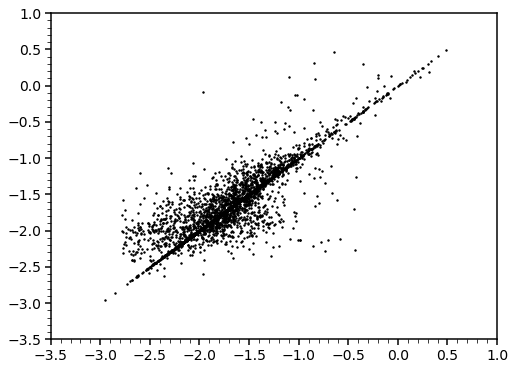

In [17]:
plt.scatter(X11m['fehadop'],X11m['fehspec'],color='black',s=2.)
plt.axis([-3.5,1.,-3.5,1.])

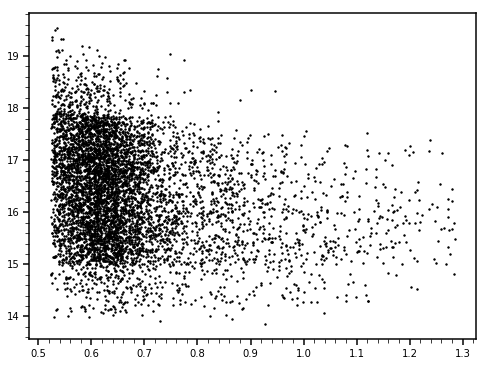

In [49]:
# verifications. 

plt.scatter(X15['gr'],X15['rmag'],color='black',s=2.)

Text(0, 0.5, 'Gaia G')

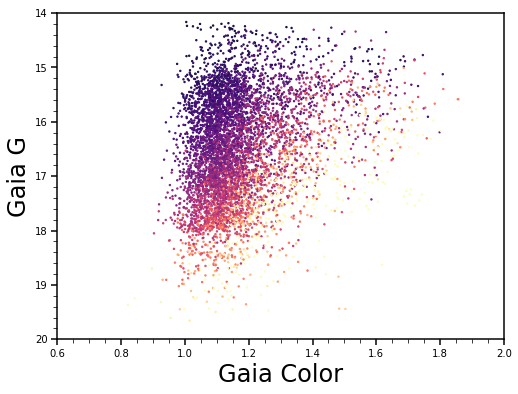

In [58]:
gaiacolor = gaiadict['gbp_rp']
gaiag = gaiadict['gphot_g_mean_mag']




plt.scatter(gaiacolor[keep],gaiag[keep],color=cm.magma(X15['d'][keep]/50.,1.),s=2.)
plt.axis([0.6,2.,20.,14.])
plt.xlabel('Gaia Color')
plt.ylabel('Gaia G')
# this doesn't really make any sense.

# biggest source of cutting down sources is g<17 selection in SDSS.

# perhaps do better by cutting on some noise tolerance in Gaia?

In [27]:
# set the coordinates
usun = 11.1
vsun = 12.24
wsun = 7.25
vcirc = 235.
rsun = 8.3 # in kpc
zsun = 30 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)

In [28]:
# set up coordinates and transform to the frame we want

c = coord.SkyCoord(ra=X15['RA'][keep]*u.deg,\
                   dec=X15['Dec'][keep]*u.deg,\
                   distance=X15['d'][keep]*u.kpc,\
                   pm_ra_cosdec=pmr[keep]*u.mas/u.yr,\
                   pm_dec=pmd[keep]*u.mas/u.yr,\
                   radial_velocity=radval[keep]*u.km/u.s)


#gc1 = c.transform_to(coord.Galactocentric) # this is default galactic
gc1 = c.transform_to(gc_frame) # for specific coordinates set above
#print(gc1.x,gc1.v_x, gc1.v_y, gc1.v_z)

In [29]:
def spherical_velocities(x,y,z,vx,vy,vz):
    """convert cartesian to spherical
    """
    rho = np.sqrt(x*x + y*y + z*z)
    r = np.sqrt(x*x + y*y)
    theta = np.arctan2(y,x)
    phi = np.arccos(z/r)
    
    vr = (x*vx + y*vy + z*vz)/rho
    vtheta = (vx*y - x*vy)/(r*r)
    vphi = ( z*(x*vx + y*vy) - r*r*vz )/(rho*rho*r)
    
    return r,theta,phi,vr,vtheta,vphi

r,theta,phi,vr,vtheta,vphi = spherical_velocities(gc1.x,gc1.y,gc1.z,gc1.v_x,gc1.v_y,gc1.v_z)

In [30]:
# also need one for viewing velocities?
# we already have this measured...

# can astropy go backwards?



In [31]:
print(np.nanmedian(np.sqrt(gc1.x*gc1.x + gc1.y*gc1.y + gc1.z*gc1.z)))

18.82515496811176 kpc


In [32]:
(gaiag[keep]-14)/6.

array([0.86060783, 0.53378   , 0.55694333, ..., 0.54131133, 0.6434625 ,
       0.711141  ])

(-400.0, 400.0)

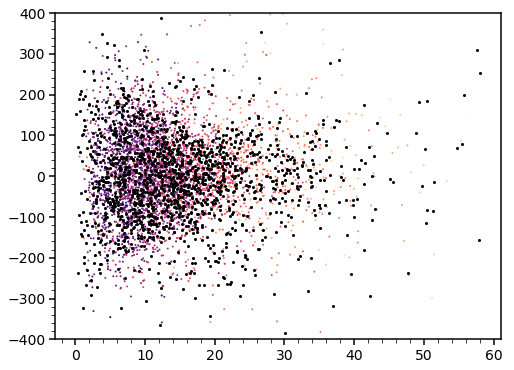

In [165]:


plt.scatter(r[nonsgrstars],gc1.v_z[nonsgrstars],\
            color=cm.magma((gaiag[keep][nonsgrstars]-14.)/6.,1.),s=1.)

plt.scatter(r[sgrstars],gc1.v_z[sgrstars],\
            color='black',s=4.)



plt.ylim(-400.,400.)


In [59]:
# plot the transformed velocities of the kept stars
plt.scatter(np.sqrt(gc1.x*gc1.x + gc1.y*gc1.y),gc1.z,color=cm.magma((np.array(gc1.v_z)+np.nanmin(np.array(gc1.v_z)))/(2.*np.nanmax(np.array(gc1.v_z))),1.),s=1.)
#plt.scatter(gc1.x,gc1.y,color='black',s=1.)

NameError: name 'gc1' is not defined

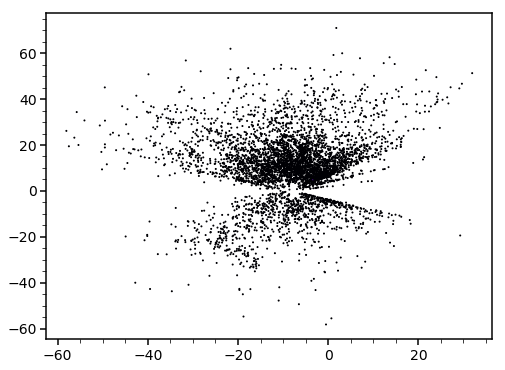

In [35]:
plt.scatter(gc1.x,gc1.z,color=cm.magma((np.array(gc1.v_z)+np.nanmin(np.array(gc1.v_z)))/(2.*np.nanmax(np.array(gc1.v_z))),1.),s=1.)



In [36]:
# set up coordinates and transform to the frame we want

c = coord.SkyCoord(ra=X11['RA'][keep][nonsgrstars]*u.deg,\
                   dec=X11['Dec'][keep][nonsgrstars]*u.deg,\
                   distance=X11['d'][keep][nonsgrstars]*u.kpc,\
                   pm_ra_cosdec=pmr[keep][nonsgrstars]*u.mas/u.yr,\
                   pm_dec=pmd[keep][nonsgrstars]*u.mas/u.yr,\
                   radial_velocity=radval[keep][nonsgrstars]*u.km/u.s)


#gc1 = c.transform_to(coord.Galactocentric) # this is default galactic
gc1 = c.transform_to(gc_frame) # for specific coordinates set above
#print(gc1.x,gc1.v_x, gc1.v_y, gc1.v_z)

NameError: name 'nonsgrstars' is not defined

In [37]:
def spherical_velocities(x,y,z,vx,vy,vz):
    """convert cartesian to spherical
    """
    rho = np.sqrt(x*x + y*y + z*z)
    r = np.sqrt(x*x + y*y)
    theta = np.arctan2(y,x)
    phi = np.arccos(z/r)
    
    vr = (x*vx + y*vy + z*vz)/rho
    vtheta = (vx*y - x*vy)/(r*r)
    vphi = ( z*(x*vx + y*vy) - r*r*vz )/(rho*rho*r)
    
    return r,theta,phi,vr,vtheta,vphi

r,theta,phi,vr,vtheta,vphi = spherical_velocities(gc1.x,gc1.y,gc1.z,gc1.v_x,gc1.v_y,gc1.v_z)

In [38]:
binsample = 400
gdist = np.array(np.sqrt(gc1.x*gc1.x + gc1.y*gc1.y + gc1.z*gc1.z))
ogdist = gdist.argsort()

binvals = int(np.floor(gdist.size))
binlist = np.zeros(binvals)
vrarr = np.zeros(binvals)
vzarr = np.zeros(binvals)
vphiarr = np.zeros(binvals)
vthetaarr = np.zeros(binvals)
vrarr2 = np.zeros(binvals)
vzarr2 = np.zeros(binvals)
vphiarr2 = np.zeros(binvals)
vthetaarr2 = np.zeros(binvals)


for ib,b in enumerate(range(binvals)):
    if ib!=(binvals-1):
        #print(gdist[ogdist[ib*binsample:(ib+1)*binsample]])
        binlist[ib] = np.nanmean(gdist[ogdist[ib*binsample:(ib+1)*binsample]])
        vrarr[ib] = np.nanmean(np.array(vr)[ogdist[ib*binsample:(ib+1)*binsample]])
        vphiarr[ib] = np.nanmean(np.array(vphi)[ogdist[ib*binsample:(ib+1)*binsample]])
        vthetaarr[ib] = np.nanmean(np.array(vtheta)[ogdist[ib*binsample:(ib+1)*binsample]])
        vzarr[ib] = np.nanmean(np.array(gc1.v_z)[ogdist[ib*binsample:(ib+1)*binsample]])
        vrarr2[ib] = np.nanmean(np.array(vr*vr)[ogdist[ib*binsample:(ib+1)*binsample]])
        vphiarr2[ib] = np.nanmean(np.array(vphi*vphi)[ogdist[ib*binsample:(ib+1)*binsample]])
        vthetaarr2[ib] = np.nanmean(np.array(vtheta*vtheta)[ogdist[ib*binsample:(ib+1)*binsample]])
        vzarr2[ib] = np.nanmean(np.array(gc1.v_z*gc1.v_z)[ogdist[ib*binsample:(ib+1)*binsample]])
    else:
        binlist[ib] = np.nanmean(gdist[ogdist[ib*binsample:]])
        vrarr[ib] = np.nanmean(np.array(vr)[ogdist[ib*binsample:]])
        vphiarr[ib] = np.nanmean(np.array(vphi)[ogdist[ib*binsample:]])
        vthetaarr[ib] = np.nanmean(np.array(vtheta)[ogdist[ib*binsample:]])
        vzarr[ib] = np.nanmean(np.array(gc1.v_z)[ogdist[ib*binsample:]])
        vrarr2[ib] = np.nanmean(np.array(vr*vr)[ogdist[ib*binsample:]])
        vphiarr2[ib] = np.nanmean(np.array(vphi*vphi)[ogdist[ib*binsample:]])
        vthetaarr2[ib] = np.nanmean(np.array(vtheta*vtheta)[ogdist[ib*binsample:]])
        vzarr2[ib] = np.nanmean(np.array(gc1.v_z*gc1.v_z)[ogdist[ib*binsample:]])


    

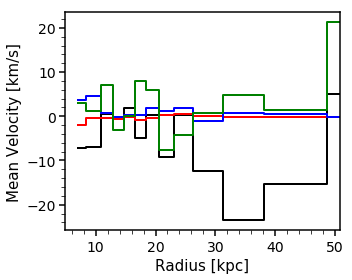

In [39]:
plt.figure(figsize=(5,4))

plt.plot(binlist,vrarr,color='black',drawstyle='steps-mid')
plt.plot(binlist,vphiarr,color='red',drawstyle='steps-mid')
plt.plot(binlist,vthetaarr,color='blue',drawstyle='steps-mid')
plt.plot(binlist,vzarr,color='green',drawstyle='steps-mid')


plt.xlabel('Radius [kpc]',size=15)
plt.ylabel('Mean Velocity [km/s]',size=15)
plt.tight_layout()


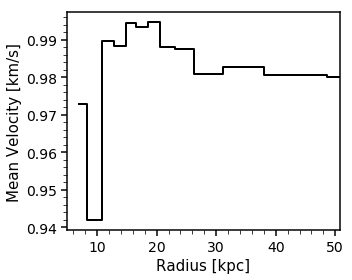

In [40]:
plt.figure(figsize=(5,4))

betaarr = 1. - 0.5*(vphiarr2+vthetaarr2)/(vrarr2)

plt.plot(binlist,betaarr,color='black',drawstyle='steps-mid')
#plt.plot(binlist,vphiarr,color='red',drawstyle='steps-mid')
#plt.plot(binlist,vthetaarr,color='blue',drawstyle='steps-mid')
#plt.plot(binlist,vzarr,color='green',drawstyle='steps-mid')


plt.xlabel('Radius [kpc]',size=15)
plt.ylabel('Mean Velocity [km/s]',size=15)
plt.tight_layout()



In [28]:

#http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_sgr-coordinate-frame.html

from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u

class Sagittarius(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the orbit
    of the Sagittarius dwarf galaxy, as described in
        http://adsabs.harvard.edu/abs/2003ApJ...599.1082M
    and further explained in
        http://www.stsci.edu/~dlaw/Sgr/.

    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    Lambda : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to Sagittarius' orbit.
    Beta : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to Sagittarius' orbit.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.

    """

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'Lambda'),
            coord.RepresentationMapping('lat', 'Beta'),
            coord.RepresentationMapping('distance', 'distance')]
    }
    
    

SGR_PHI = (180 + 3.75) * u.degree # Euler angles (from Law & Majewski 2010)
SGR_THETA = (90 - 13.46) * u.degree
SGR_PSI = (180 + 14.111534) * u.degree


# Generate the rotation matrix using the x-convention (see Goldstein)
D = rotation_matrix(SGR_PHI, "z")
C = rotation_matrix(SGR_THETA, "x")
B = rotation_matrix(SGR_PSI, "z")
A = np.diag([1.,1.,-1.])
SGR_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, Sagittarius)
def galactic_to_sgr():
    """ Compute the transformation matrix from Galactic spherical to
        heliocentric Sgr coordinates.
    """
    return SGR_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, Sagittarius, coord.Galactic)
def sgr_to_galactic():
    """ Compute the transformation matrix from heliocentric Sgr coordinates to
        spherical Galactic.
    """
    return matrix_transpose(SGR_MATRIX)





In [61]:
sgr = c.transform_to(Sagittarius) # for specific coordinates set above



NameError: name 'c' is not defined

In [93]:
sgr.Beta.size

4944

1547


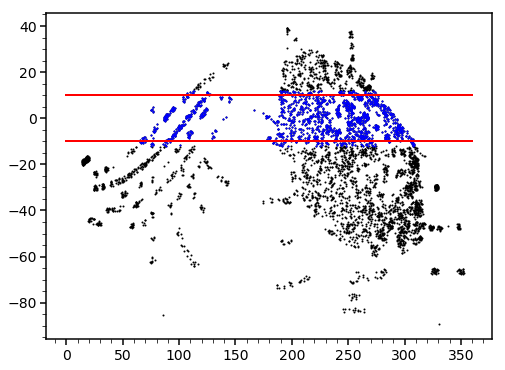

In [43]:
sgr = c.transform_to(Sagittarius) # for specific coordinates set above

plt.scatter(sgr.Lambda,sgr.Beta,color='black',s=1.)
plt.plot([0.,360.],[10.,10.],color='red')
plt.plot([0.,360.],[-10.,-10.],color='red')

sgrstars = np.where( (np.abs(np.array(sgr.Beta))<12.))[0]
nonsgrstars = np.where( (np.abs(np.array(sgr.Beta))>12.))[0]


print(sgrstars.size)


plt.scatter(sgr.Lambda[sgrstars],sgr.Beta[sgrstars],color='blue',s=1.)




In [44]:
# find distances? in bins

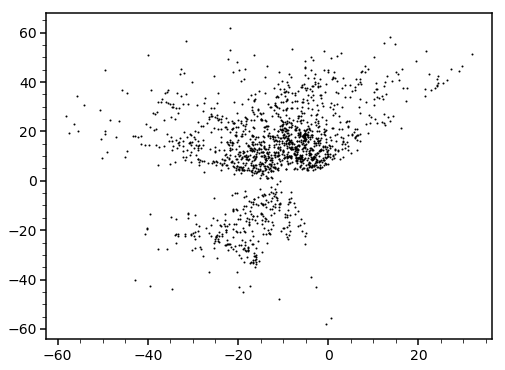

In [45]:
plt.scatter(gc1.x[sgrstars],gc1.z[sgrstars],color='black',s=1.)



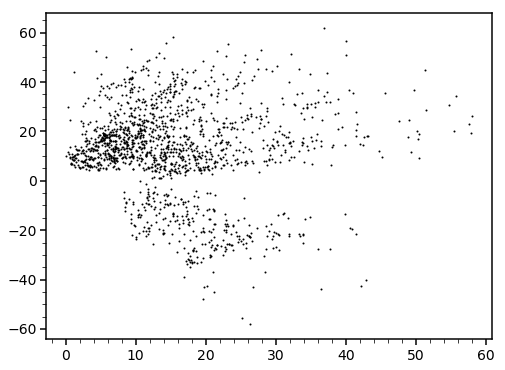

In [46]:
plt.scatter(np.sqrt(gc1.x*gc1.x + gc1.y*gc1.y)[sgrstars],gc1.z[sgrstars],color='black',s=1.)



In [47]:
# need some sort of smart tuning for the rotation curve like Bovy. 
# Where are those mclure data points?
# update: they are in fixedpotential/resonance-locations.

In [48]:
# put orbits in system units

veltrans = vcirc/1.4
veltrans = 260./1.4 # best to match MW rotation curve
scltrans = 300.


ODict = {}

for o in range(0,len(gc1.x)):
    ODict[o] = {'start_pos':[np.array(gc1.x)[o]/scltrans,np.array(gc1.y)[o]/scltrans,np.array(gc1.z)[o]/scltrans] ,\
                'start_vel':[np.array(gc1.v_x)[o]/veltrans,np.array(gc1.v_y)[o]/veltrans,np.array(gc1.v_z)[o]/veltrans]}


      
      

## Integrate orbits

Now we have the velocities that we need to be able to integrate orbits.

So many of the orbits are clearly still rotating with the disk, so it's unclear how we can claim that so many must be halo stars.

In [49]:
import modelpotential as mp

# the fiducial model
indir = '/Volumes/SIMSET/Disk001/'
runtag = 'run001s'
cachefile = '.eof.cache.file'

# use 20 to get the initial settling
F = mp.initialize_potential(indir,runtag,cachefile,timein=20,usebar=False)

# make a backup copy before modifying anything
G = copy.deepcopy(F)

Disk calculation time: 6.2 seconds
0.04000000000000003
Halo calculation time: 2.6 seconds
Total time elapsed: 8.7 seconds


In [50]:
# reduce to the monopole and first few terms

oldSL = F.SL.expcoef
newSL = np.zeros_like(F.SL.expcoef)
#print(newSL)
newSL[0,0:4] = oldSL[0,0:4]
F.SL.expcoef = newSL#np.zeros([F.SL.expcoef.shape[0],F.SL.expcoef.shape[1]])

oldcos = F.EOF.cos
newcos = np.zeros_like(oldcos)
F.EOF.sin = np.zeros_like(oldcos)
newcos[0,0:4] = oldcos[0,0:4]
F.EOF.cos = newcos

F.halofac = -(1./np.pi)



In [51]:
# need to verify that the Z direction is going the right way...

In [52]:
#ODict = {}
#ODict[1] = {'start_pos':[-0.00575,0.04903,-0.04004] ,'start_vel':[-1.26488,1.06353,-1.37904]}

t1 = time.time()

OLog = {}
for o in range(0,len(gc1.x)):
    if (o%100==0): print(o)
    try:
        OLog[o] = mp.int_orbit(F,ODict,o,rotfreq=0.,dt=0.0005,nint=1000,max_m =0,max_l=0,force=False)
        OLog[o]['R'] = np.sqrt(OLog[o]['X']*OLog[o]['X'] + OLog[o]['Y']*OLog[o]['Y'])
        OLog[o]['R3'] = np.sqrt(OLog[o]['X']*OLog[o]['X'] + OLog[o]['Y']*OLog[o]['Y'] + OLog[o]['Z']*OLog[o]['Z'])
        OLog[o]['VR'] = np.abs(OLog[o]['X']*OLog[o]['VX'] + OLog[o]['Y']*OLog[o]['VY'])/(OLog[o]['R'])
        OLog[o]['TH'] = np.arctan2(OLog[o]['TY'],OLog[o]['TX'])
    except:
        # also buffer this to have nans
        OLog[o] = OLog[o-1]
        OLog[o]['R3'] = np.nan*OLog[o]['R']
    #print(np.nanmin(Orbit['R']),np.nanmax(Orbit['R']))


print('Elapsed time (minutes):',(time.time()-t1)/60.)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
Elapsed time (minutes): 71.36800095240275


In [58]:
rperi = np.zeros(len(gc1.x))
rapo  = np.zeros(len(gc1.x))
zdiff = np.zeros(len(gc1.x))
zmax  = np.zeros(len(gc1.x))

for o in range(0,len(gc1.x)):
    #print(np.nanmin(OLog[o]['R3']))
    rperi[o] = np.nanmin(OLog[o]['R3'])*scltrans
    rapo[o] = np.nanmax(OLog[o]['R3'])*scltrans
    zdiff[o] = np.nanmax(OLog[o]['Z'])*np.nanmin(OLog[o]['Z'])
    zmax[o] = np.nanmax(np.abs(OLog[o]['Z']))*scltrans

In [65]:
np.array(BHB.b[0])

array(-37.5436795)

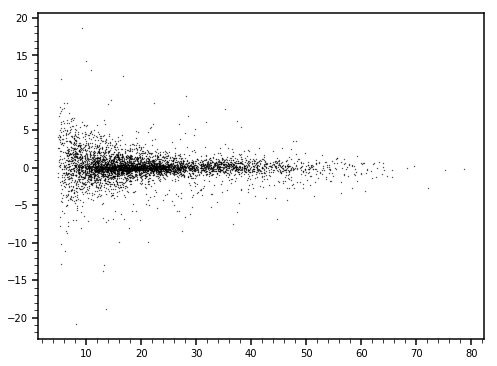

In [751]:
plt.scatter(radj,dmulj,color='black',s=0.1)

In [754]:
print(np.array(BHB.b)-dBj)

[ 1.99212852  2.17076603  2.03208416 ... -1.30181272 -2.33538575
  5.47616143]


In [728]:
# print to a file...

# with a flipped vb ONLY?



#plt.scatter(BHB.l,BHB.b,color='black',s=0.1)
"""
BHB.l
BHB.b
BHB.d
BHB.vr
BHB.vtheta <-actually phi, mislabeled
BHB.vphi <-actually theta, mislabeled
"""

#f = open('/Users/mpetersen/Downloads/BHB_Xue_full.txt','w')
f = open('/Users/mpetersen/Dropbox/mike/data/BHB_Xue_full.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; \
       vx [km/s]; vy [km/s]; vz [km/s]; \
       l [deg]; b [deg]; d [kpc]; \
       vphi [km/s]; vtheta [km/s]; vlos [km/s]; \
       rapo [kpc]; rperi [kpc]; zmax [kpc]; \
       Sgr Lambda [deg];Sgr Beta [deg]',file=f)


targetnum = 200000
i=1000000
acc = 0
#for i in range(0,PSPDump.xpos.size):
for i in range(0,len(BHB.l)):
    
    print(np.round(np.array(BHB.x[i]),2),\
          np.round(np.array(BHB.y[i]),2),\
          np.round(np.array(BHB.z[i]),2),\
          np.round(np.array(BHB.vx[i]),2),\
          np.round(np.array(BHB.vy[i]),2),\
          np.round(np.array(BHB.vz[i]),2),\
          np.round(np.array(BHB.l[i]),2),\
          np.round(np.array(BHB.b[i]),2),\
              np.round(np.array(BHB.d[i]),2),\
              np.round(np.array(BHB.vphi[i]),3),\
              np.round(np.array(BHB.vtheta[i]),3),\
              np.round(np.array(BHB.vr[i]),2),\
              np.round(rapo[i],2),\
              np.round(rperi[i],2),\
              np.round(zmax[i],2),\
              np.round(np.array(sgr.Lambda[i]),2),\
              np.round(np.array(sgr.Beta[i]),2),\
              file=f)

    
f.close()














In [723]:


In = np.genfromtxt('/Users/mpetersen/Downloads/BHB_Xue_full.txt',skip_header=1)

x = In[:,0]
y = In[:,1]
z = In[:,2]
vx = In[:,3]
vy = In[:,4]
vz = In[:,5]
l = In[:,6]
b = In[:,7]
dist = In[:,8]
vphi= In[:,9]
vtheta= In[:,10]
vlos= In[:,11]
rapo= In[:,12]
rperi= In[:,13]
zmax = In[:,14]
sLambda = In[:,15]
sBeta = In[:,10]



In [724]:
vx

array([269.29,  26.26, -98.43, ..., -56.69, -21.06, 372.46])

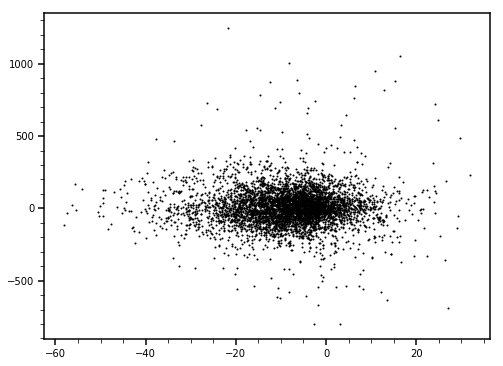

In [727]:
plt.scatter(x,vx,color='black',s=1.)

In [100]:


In = np.genfromtxt('/Users/mpetersen/Downloads/BHB_Xue.txt',skip_header=1)

l = In[:,0]
b = In[:,1]
dist = In[:,2]
vphi= In[:,3]
vtheta= In[:,4]
vlos= In[:,5]
rapo= In[:,6]
rperi= In[:,7]
zmax = In[:,8]
sLambda = In[:,9]
sBeta = In[:,10]


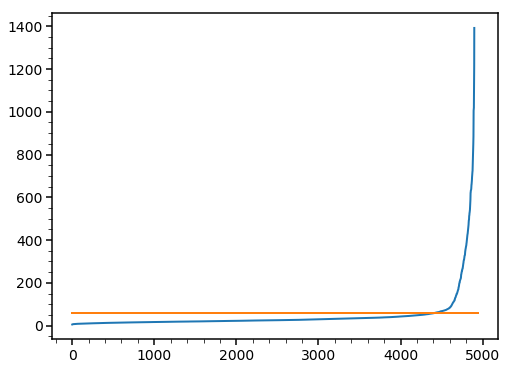

In [71]:
plt.plot(rapo[rapo.argsort()])
plt.plot([0,len(rapo)],[60.,60.])

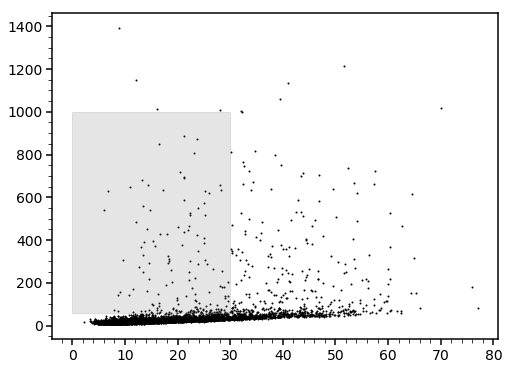

In [73]:
plt.scatter(dist,rapo,s=1.,color='black')
plt.fill_between([0.,30.],[60.,60.],[1000,1000],color='gray',alpha=0.2)

In [76]:
dcut = np.where((rapo>50.)&(dist<30.))[0]
print(dcut.size)

161


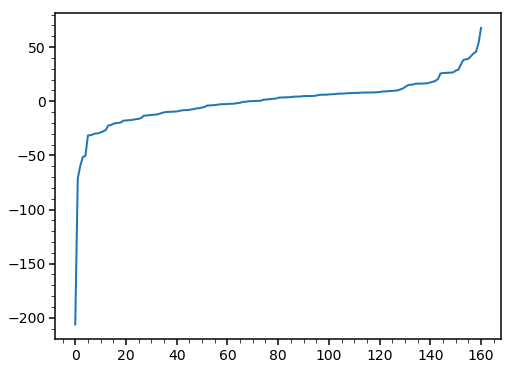

In [91]:
plt.plot(vtheta[dcut][vtheta[dcut].argsort()])

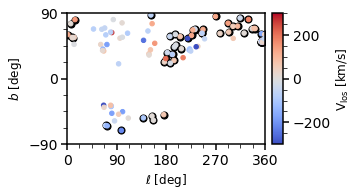

In [350]:
#velstretch = 

fig = plt.figure(figsize=(5,2.5))
ax1 = fig.add_axes([0.19,0.23,0.55,0.73])
ax2 = fig.add_axes([0.76,0.23,0.03,0.73])


rapomax = 50.
dcut2 = np.where((rapo>rapomax)&(dist<30.)&(np.abs(sBeta)<15.))[0]
dcut2 = np.where((rapo>rapomax)&(np.abs(sBeta)<15.))[0]
dcut2 = np.where((dist>rapomax)&(np.abs(sBeta)<15.))[0]


l[l<0]+=360.

ax1.scatter(l[dcut2],b[dcut2],color='black',s=50.)

dcut = np.where((rapo>rapomax)&(dist<30.))[0]
dcut = np.where((rapo>rapomax))[0]#&(dist<30.))[0]
dcut = np.where((dist>rapomax))[0]#&(dist<30.))[0]



ax1.scatter(l[dcut],b[dcut],color=cm.coolwarm((vlos[dcut]+300.)/600.,1.),s=20.)

#ax1.scatter(l[dcut],b[dcut],color=cm.coolwarm((vtheta[dcut]+100.)/200.,1.),s=20.)
#ax1.scatter(l[dcut],b[dcut],color=cm.coolwarm((vphi[dcut]+100.)/200.,1.),s=20.)


ax1.set_xlabel('$\ell$ [deg]',size=12)
ax1.set_ylabel('$b$ [deg]',size=12)
ax1.set_xticks([0.,90.,180.,270.,360.])
ax1.set_yticks([-90.,0.,90.])
ax1.axis([0.,360.,-90.,90.])

norm = mpl.colors.Normalize(vmin=-300, vmax=300)
#norm = mpl.colors.Normalize(vmin=-150, vmax=150)

#cb1 = mpl.colorbar.ColorbarBase(ax5, cmap=cmap,norm=norm)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cm.coolwarm,norm=norm)#,orientation='horizontal',ticklocation='top')
cb1.set_label('V$_{\\rm los}$ [km/s]',size=12)
#cb1.set_label('V$_{\\theta}$ [km/s]',size=12)
#cb1.set_label('V$_{\\phi}$ [km/s]',size=12)




#plt.tight_layout()
#plt.savefig('/Users/mpetersen/Downloads/BHBstars_theta.png',dpi=300)


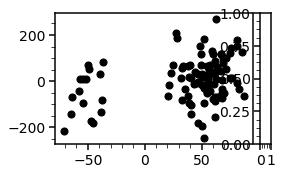

In [352]:

fig = plt.figure(figsize=(5,2.5))
ax1 = fig.add_axes([0.19,0.23,0.55,0.73])
ax2 = fig.add_axes([0.76,0.23,0.03,0.73])


rapomax = 50.
dcut2 = np.where((rapo>rapomax)&(dist<30.)&(np.abs(sBeta)<15.))[0]
dcut2 = np.where((rapo>rapomax)&(np.abs(sBeta)<15.))[0]
dcut2 = np.where((dist>rapomax))[0]#&(np.abs(sBeta)<15.))[0]


l[l<0]+=360.

ax1.scatter(b[dcut2],vlos[dcut2],color='black',s=50.)



In [171]:
metalvals = bhbcat['feh']

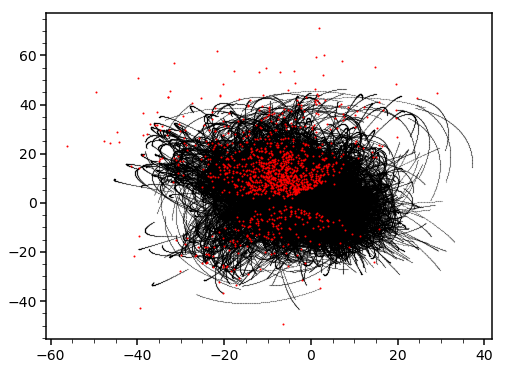

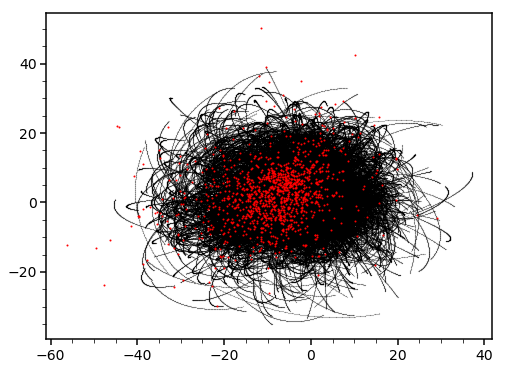

In [172]:
plt.figure()

lenscale=300.

for o in range(0,len(gc1.x)):
    if (rapo[o] < 50.):# & (gaiadic[o] < -2.):
        plt.scatter(lenscale*OLog[o]['X'][0:200],lenscale*OLog[o]['Z'][0:200],color='black',s=0.01)
    
    
plt.scatter(gc1.x[metalvals < -2.],gc1.z[metalvals < -2.],color='red',s=1.)


plt.figure()

lenscale=300.

for o in range(0,len(gc1.x)):
    if (rapo[o] < 50.):# & (metalvals[o] < -2.):
        plt.scatter(lenscale*OLog[o]['X'][0:200],lenscale*OLog[o]['Y'][0:200],color='black',s=0.01)
    
    
plt.scatter(gc1.x[metalvals < -2.],gc1.y[metalvals < -2.],color='red',s=1.)

In [182]:
rapo.size*0.12

593.28

(0.0, 100.0)

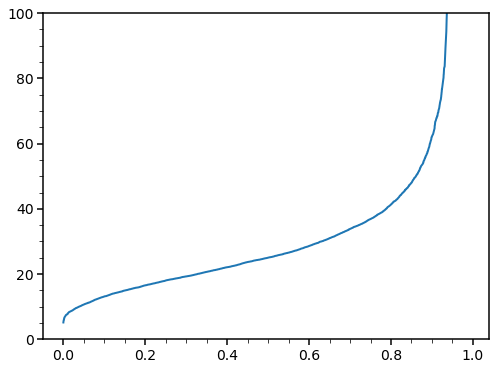

In [180]:
plt.plot(np.linspace(0.,1.,rapo.size),rapo[rapo.argsort()])
plt.ylim(0.,100.)


In [176]:
eccen = (rapo-rperi)/(rapo+rperi)

print(np.nanmean(rapo[metalvals>-1.5]))
print(np.nanmean(rapo[(metalvals<-2.) & (eccen>0.9) & (rapo<50.)]))
print(np.nanstd(rapo[(metalvals<-2.) & (eccen>0.9) & (rapo<50.)]))

65.59869863013698
24.349090909090908
9.785017003532099


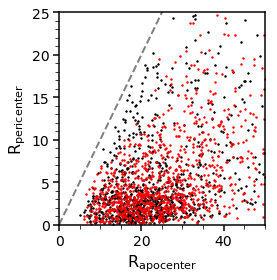

In [177]:
plt.figure(figsize=(4,4))

#metalvals = fehvals[keep]
plt.scatter(rapo[(rperi>0) & (rapo<50.)& (metalvals>-1.5)],\
            rperi[(rperi>0) & (rapo<50.) & (metalvals>-1.5)],\
            color='black',s=2.)

plt.scatter(rapo[(rperi>0) & (rapo<50.)& (metalvals<-2.)],\
            rperi[(rperi>0) & (rapo<50.) & (metalvals<-2.)],\
            color='red',s=2.)

#            color=cm.magma((metalvals-np.nanmin(metalvals))/2.2),s=3.)
plt.plot([0.,50.],[0.,50.],color='gray',linestyle='dashed')
plt.axis([0.,50.,0.,25.])
plt.xlabel('R$_{\\rm apocenter}$',size=16)
plt.ylabel('R$_{\\rm pericenter}$',size=16)

plt.tight_layout()
plt.savefig('ApoPeri.png',dpi=300)

924
1015


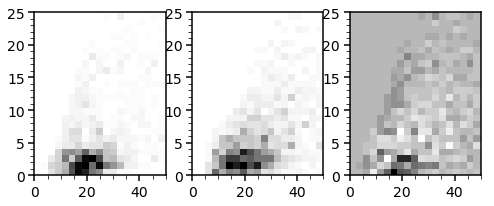

In [178]:
apovals = np.linspace(0.,50.,20)
perivals = np.linspace(0.,25.,25)

nhigh = rapo[(rperi>0) & (rapo<50.) & (metalvals>-1.5)].size
print(nhigh)
lowmetal,xedges,yedges = np.histogram2d(rapo[(rperi>0) & (rapo<50.) & (metalvals>-1.5)],\
                                        rperi[(rperi>0) & (rapo<50.) & (metalvals>-1.5)],bins=(apovals,perivals))
xx,yy = np.meshgrid(xedges,yedges)

fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.pcolormesh(xx,yy,lowmetal.T,cmap=cm.Greys)

nlow = rapo[(rperi>0) & (rapo<50.) & (metalvals<-2.)].size
print(nlow)
lowmetal2,xedges,yedges = np.histogram2d(rapo[(rperi>0) & (rapo<50.) & (metalvals<-2.)],\
                                        rperi[(rperi>0) & (rapo<50.) & (metalvals<-2.)],bins=(apovals,perivals))
xx,yy = np.meshgrid(xedges,yedges)


ax2.pcolormesh(xx,yy,lowmetal2.T,cmap=cm.Greys)

ax3.pcolormesh(xx,yy,lowmetal.T-lowmetal2.T,cmap=cm.Greys)





In [ ]:
# demo an orbit or two

Orbit = OLog[903]

fig = plt.figure(figsize=(7,3))
ax1 = fig.add_axes([0.15,0.25,0.28,0.7])
ax2 = fig.add_axes([0.58,0.25,0.28,0.7])

ax1.plot(100.*Orbit['TX'],100.*Orbit['TY'],color='black')
maxval = 100.*1.2*np.max([np.abs(Orbit['TX']),np.abs(Orbit['TY']),np.abs(Orbit['Z'])])
ax1.axis([-maxval,maxval,-maxval,maxval])


ax2.plot(100.*Orbit['TX'],100.*Orbit['Z'],color='black')
ax2.axis([-maxval,maxval,-maxval,maxval])

for ax in [ax1,ax2]:
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')

ax1.set_xlabel('X$_{\\rm bar}$ [a]')
ax2.set_xlabel('X$_{\\rm bar}$ [a]')


ax1.set_ylabel('Y$_{\\rm bar}$ [a]')
ax2.set_ylabel('Z [a]')





In [ ]:
# check out the options for bulking up the disk

H = copy.deepcopy(F)
H.EOF.cos = 2.*F.EOF.cos

F.halofac = -(1./np.pi)
H.halofac = -(1./np.pi)


H.rotation_curve()
F.rotation_curve()



plt.plot(H.rvals,H.total_rotation,color='gray')
plt.plot(H.rvals,H.disk_rotation,color='black')
plt.plot(H.rvals,H.halo_rotation,color='red')

plt.plot(F.rvals,F.total_rotation,linestyle='dashed',color='gray')
plt.plot(F.rvals,F.disk_rotation,color='black',linestyle='dashed')
plt.plot(F.rvals,F.halo_rotation,color='red',linestyle='dashed')




In [ ]:
o =1000
G.EOF.cos = 1.*F.EOF.cos
Orbit = mp.int_orbit(G,ODict,o,rotfreq=0.,dt=0.001,nint=1000,max_m =0,max_l=0,force=True)
Orbit['R'] = np.sqrt(Orbit['X']*Orbit['X'] + Orbit['Y']*Orbit['Y'])
#plt.plot(300.*Orbit['R'],300.*Orbit['Z'],color='red')
plt.plot(Orbit['Z'],Orbit['FZ'],color='red')

H.EOF.cos = 2.*F.EOF.cos
Orbit = mp.int_orbit(H,ODict,o,rotfreq=0.,dt=0.001,nint=1000,max_m =0,max_l=0,force=True)
Orbit['R'] = np.sqrt(Orbit['X']*Orbit['X'] + Orbit['Y']*Orbit['Y'])
#plt.plot(300.*Orbit['R'],300.*Orbit['Z'],color='blue')
plt.plot(Orbit['Z'],Orbit['FZ'],color='blue')

#I.EOF.cos = F.EOF.cos
#Orbit = mp.int_orbit(I,ODict,o,rotfreq=0.,dt=0.001,nint=1000,max_m =0,max_l=0,force=True)
#Orbit['R'] = np.sqrt(Orbit['X']*Orbit['X'] + Orbit['Y']*Orbit['Y'])
#plt.plot(300.*Orbit['R'],300.*Orbit['Z'],color='black')
#plt.plot(Orbit['Z'],Orbit['FZ'],color='black')




Increasing the disk mass leads to unchanged apocenters, increased pericenters for some orbits. The opposite for others.

And ENTIRELY different orbits for others.

In [ ]:
diff = X11['gmag'] - absg
dist = 0.01*10.**(0.2*diff)


In [ ]:
plt.scatter(X11['d'],dist,color='black',s=2.)
plt.xlabel('Xue 2011 distance')
plt.ylabel('Updated distance')
plt.tight_layout()

# from this plot, why did they bother updating?

In [ ]:
print(X11['Dec'][int((X11m['Name'][0].decode()).strip('S'))])
print(X11m['dec'][0])

In [ ]:
# check out the distribution of metallicities

met = fehvals[keep]

print(len(np.where(met<-2.)[0]))

print(len(np.where(met>-1.5)[0]))


plt.plot(met[met.argsort()])
plt.ylim(-5.,1.)

In [ ]:
# make a cut similar to the one in Deason 2018

w = np.where(gaiag < 17.)
print(len(w[0]))

plt.scatter(np.sqrt(X11['x']*X11['x'] + X11['y']*X11['y'])[w],X11['z'][w],color=cm.magma((radval[w]+400.)/800.,1.),s=2.)

#plt.scatter(X11['x'],X11['z'],color=cm.magma((gaiag-12.5)/8.,1.),s=2.)
#plt.scatter(X11['x'],X11['z'],color=cm.magma(X11['d']/50.,1.),s=2.)

plt.xlabel('Radius [kpc]')
plt.ylabel('Z [kpc]')


## Appendix 1: Executed Queries

In [483]:

##Table1
#objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid

C = np.genfromtxt('/Users/mpetersen/Downloads/Skyserver_Radial4_4_2020 11_14_36 PM.csv',\
                 dtype={'names': ("objid","ra","dec",\
                                         "u","g","r","i","z",\
                                         "run","rerun","camcol","field",\
                                         "specobjid","class","redshift",\
                                         "plate","mjd","fiberid"),\
                             'formats': ('S20','f8','f8',\
                                        'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'S20','S20','f8',\
                                        'i4','i4','i4')},\
                 skip_header=2,delimiter=',')


In [608]:
# segue is 1660/3480

segue = np.where( (C['plate']>1660) & (C['plate']<3480))[0]
segue = np.where( (C['plate']>266) & (C['plate']<3006))[0]


print(segue.size)


10378


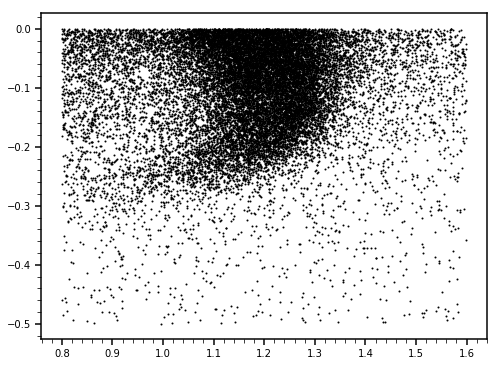

In [484]:
C['class'][C['class']==b'STAR'].size

gr = C['g']-C['r']
ug = C['u']-C['g']
w = np.where(C['class']==b'STAR')[0]
plt.scatter(ug[w],gr[w],color='black',s=1.)

In [610]:
def print_file_name(indx,file):
    #print(C['plate'][indx].decode()+'/spec-'+C['plate'][indx].decode()+\
    #                               '-'+C['mjd'][indx].decode()+\
    #                               '-'+C['fiberid'][indx].decode()+'.fits')

    print('{0:04d}/spec-{1:04d}-{2}-{3:04d}.fits'.format(C['plate'][indx],\
                                                 C['plate'][indx],\
                                                 C['mjd'][indx],\
                                                 C['fiberid'][indx]),file=file)


f = open('/Users/mpetersen/Downloads/SEGUE/fullspec.txt','w')
for i in range(0,segue.size):
    print_file_name(segue[i],file=f)
    
f.close()

#/usr/local/Cellar/wget/1.20.3_2/bin/wget -i fullspec.txt -B http://data.sdss3.org/sas/dr9/sdss/spectro/redux/26/spectra/



failed for /Users/mpetersen/Downloads/SEGUE/spec-0701-52179-0443.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0755-52235-0259.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0772-52375-0091.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0802-52289-0423.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0803-52318-0598.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0827-52312-0523.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0852-52375-0017.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0885-52379-0494.fits


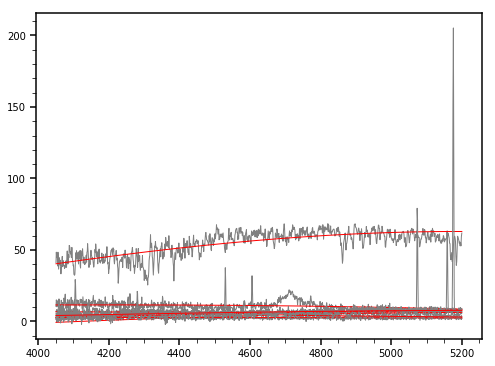

In [652]:
# prototyper for when things are stuck:


for indx,infile in enumerate(F[400:500]):
    
    hdul = fits.open(infile)

    data = np.array(hdul[1].data)

    wave = 10.**(data['loglam'])
    flux = data['flux']
    outwave,outflux = normalise_continuum(wave,flux)
    
    #

    try:
        fms[indx],D02s[indx],bs[indx],cs[indx] = fit_hgamma(outwave,outflux)
    except:
        print('failed for {}'.format(infile))
        outwave,outflux,fitflux = normalise_continuum(wave,flux,diagnostic=True)
        plt.plot(outwave,outflux,color='gray',lw=1.)
        plt.plot(outwave,fitflux,color='red',lw=1.)





In [702]:
import glob

F = glob.glob('/Users/mpetersen/Downloads/SEGUE/*.fits')


HG = {}
HG['fms'] = np.zeros(len(F))
HG['D02s'] = np.zeros(len(F))
HG['cs'] = np.zeros(len(F))
HG['bs'] = np.zeros(len(F))
HG['x0s'] = np.zeros(len(F))
HG['efms'] = np.zeros(len(F))
HG['eD02s'] = np.zeros(len(F))
HG['ecs'] = np.zeros(len(F))
HG['ebs'] = np.zeros(len(F))
HG['ex0s'] = np.zeros(len(F))

HD = {}
HD['fms'] = np.zeros(len(F))
HD['D02s'] = np.zeros(len(F))
HD['cs'] = np.zeros(len(F))
HD['bs'] = np.zeros(len(F))
HD['x0s'] = np.zeros(len(F))

import warnings
warnings.simplefilter('ignore', np.RankWarning)

f = open('/Users/mpetersen/Downloads/SEGUE/allrejected.txt','w')

for indx,infile in enumerate(F):
    
    hdul = fits.open(infile)

    data = np.array(hdul[1].data)

    wave = 10.**(data['loglam'])
    flux = data['flux']
    outwave,outflux = normalise_continuum(wave,flux)
    
    #plt.plot(outwave,outflux)

    badflag = 0
    try:
        #fms[indx],D02s[indx],bs[indx],cs[indx] = fit_hdelta(outwave,outflux)

        
        HG['fms'][indx],HG['D02s'][indx],HG['bs'][indx],HG['cs'][indx],HG['x0s'][indx],\
        HG['efms'][indx],HG['eD02s'][indx],HG['ebs'][indx],HG['ecs'][indx],HG['ex0s'][indx] = fit_hgamma(outwave,outflux)
    except:
        
        # from testing above, it's fairly clear that the failures result from non-stellar sources.
        # so what are they?? might need to look into that
        badflag += 1
        
    try:
        HD['fms'][indx],HD['D02s'][indx],HD['bs'][indx],HD['cs'][indx],HD['x0s'][indx] = fit_hdelta(outwave,outflux)

    except:
        badflag += 1
    
    if badflag==2:
        # print obviously bad files so that we can eliminate them for space considerations

        print(infile,file=f)


f.close()

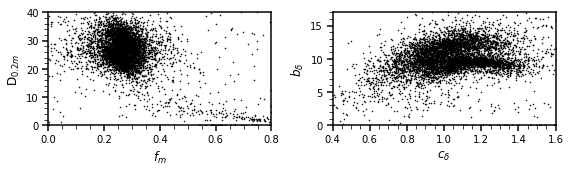

In [700]:

# h delta plot
fig = plt.figure(figsize=(8,2.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(HD['fms'],HD['D02s'],color='black',s=0.3)
ax1.axis([0.,0.8,0.,40.])
ax1.set_xlabel('$f_m$',size=12)
ax1.set_ylabel('D$_{0.2m}$',size=12)

ax2.scatter(HD['cs'],HD['bs'],color='black',s=0.3)
ax2.axis([0.4,1.6,0.,17.])
ax2.set_xlabel('$c_\delta$',size=12)
ax2.set_ylabel('$b_\delta$',size=12)

fig.tight_layout()

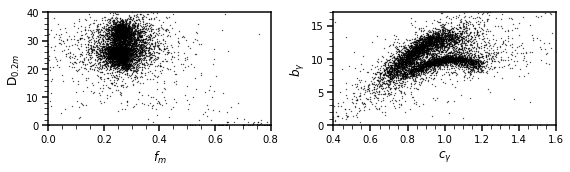

In [699]:

# h gamma plot
fig = plt.figure(figsize=(8,2.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(HG['fms'],HG['D02s'],color='black',s=0.1)
ax1.axis([0.,0.8,0.,40.])
ax1.set_xlabel('$f_m$',size=12)
ax1.set_ylabel('D$_{0.2m}$',size=12)

ax2.scatter(HG['cs'],HG['bs'],color='black',s=0.1)
ax2.axis([0.4,1.6,0.,17.])
ax2.set_xlabel('$c_\gamma$',size=12)
ax2.set_ylabel('$b_\gamma$',size=12)

fig.tight_layout()

[-600, 600, -600, 600]

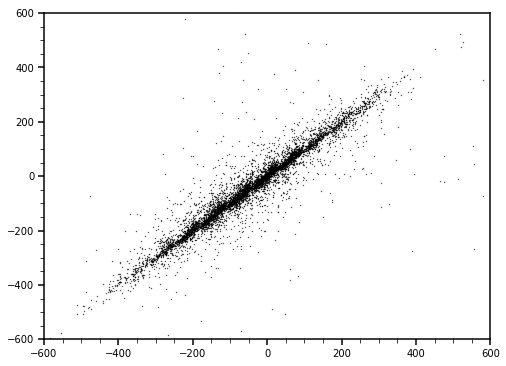

In [701]:
velocitiesHG = speed_of_light*(HG['x0s']-balmer['gamma'])/balmer['gamma']
velocitiesHD = speed_of_light*(HD['x0s']-balmer['delta'])/balmer['delta']


plt.scatter(velocitiesHG,velocitiesHD,color='black',s=0.1)
plt.axis([-600,600,-600,600])


(-600.0, 600.0)

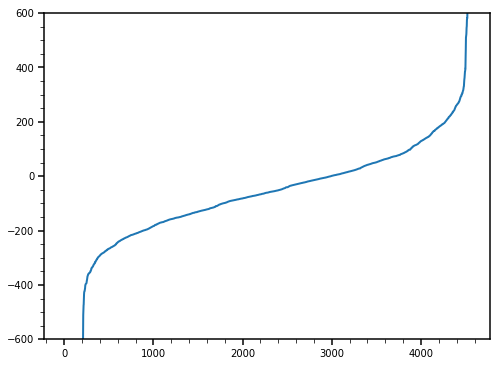

In [688]:
plt.plot(velocities[velocities.argsort()])
plt.ylim(-600.,600.)

In [500]:

hdul.info()

Filename: /Users/mpetersen/Downloads/SEGUE/spec-2047-53732-0552.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3831R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   
  4  B2-00035942-00035940-00035941    1 BinTableHDU    146   2047R x 7C   [E, E, E, J, E, E, E]   
  5  B2-00035943-00035940

In [593]:
print(data['ivar'])
print(data['flux'])

[0.02843923 0.03051122 0.03058311 ... 0.45608446 0.43514284 0.41500518]
[100.01546   99.661964  98.72565  ...  18.909353  18.134226  14.046533]


In [675]:
balmer = {}
balmer['alpha'] = 6563.
balmer['beta'] = 4861.
balmer['gamma'] = 4341.692
balmer['delta'] = 4102.892


In [648]:
data.shape
#plt.plot(,data['flux'])
#plt.xlim(3000.,5000.)



def normalise_continuum(wave,flux,diagnostic=False):
    ww = np.where( ((wave>4200) & (wave<4300)) |\
                  ((wave>4400) & (wave<4800)) |\
                  ((wave>4950) & (wave<5500)))
    
    w = np.where((wave>4050) & (wave<5200))
    p = np.polyfit(wave[ww],flux[ww],4)
    pfunc = np.poly1d(p)

    if diagnostic:
        return wave[w],flux[w],pfunc(wave[w])
        
    else:
        return wave[w],flux[w]/pfunc(wave[w])


infile = '/Users/mpetersen/Downloads/SEGUE/spec-2047-53732-0552.fits'
hdul = fits.open(infile)
data = np.array(hdul[1].data)


wave = 10.**(data['loglam'])
flux = data['flux']
outwave,outflux = normalise_continuum(wave,flux)

fm,D02,b,c = fit_hgamma(outwave,outflux)



#plt.plot(wave[w],flux[w],color='black')
#plt.plot(wave[w],pfunc(wave[w]),color='red')
#plt.plot(outwave,outflux,color='red')
#plt.plot([np.nanmin(wave[w]),np.nanmax(wave[w])],[1.,1.],color='gray',linestyle='dashed')

In [590]:
def sersic(x,a,b,c,x0,level=1.):
    
    return level - a*np.exp(- (np.abs(x-x0)/b)**c)
    

In [695]:

from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.optimize import brentq




def fit_hdelta(wave,flux):
    
    hdelta = np.where( (wave>4050) & (wave<4200))

    popt, pcov = curve_fit(sersic, wave[hdelta],flux[hdelta],p0=(0.8,10.,1.,4102.))

    fm = 1.-popt[0]
    b = popt[1]
    c = popt[2]
    x0 = popt[3]
    
    loroot = brentq(sersic,0,popt[3],args=(popt[0],popt[1],popt[2],popt[3],0.2))
    hiroot = brentq(sersic,popt[3],2.*popt[3],args=(popt[0],popt[1],popt[2],popt[3],0.2))

    D02 = hiroot - loroot
    
    return fm,D02,b,c,x0




def fit_hgamma(wave,flux,error=True):
    
    hgamma = np.where( (wave>4250) & (wave<4450))

    popt, pcov = curve_fit(sersic, wave[hgamma],flux[hgamma],p0=(0.8,10.,1.,4350.))

    
    fm = 1.-popt[0]
    b = popt[1]
    c = popt[2]
    x0 = popt[3]

    perr = np.sqrt(np.diag(pcov))
    efm = perr[0]
    eb = perr[1]
    ec = perr[2]
    ex0 = perr[3]
    
    loroot = brentq(sersic,0,popt[3],args=(popt[0],popt[1],popt[2],popt[3],0.2))
    hiroot = brentq(sersic,popt[3],2.*popt[3],args=(popt[0],popt[1],popt[2],popt[3],0.2))

    D02 = hiroot - loroot
    
    loroot = brentq(sersic,0,popt[3],args=(popt[0]-perr[0],popt[1]-perr[1],popt[2]-perr[2],popt[3]-perr[3],0.2))
    hiroot = brentq(sersic,popt[3],2.*popt[3],args=(popt[0]-perr[0],popt[1]-perr[1],popt[2]-perr[2],popt[3]-perr[3],0.2))

    # need to figure out if this is a good error estimate...
    eD02 = hiroot - loroot

    if error:
        return fm,D02,b,c,x0,efm,eD02,eb,ec,ex0
    
    else:
        return fm,D02,b,c,x0


#plt.plot(wave[hgamma],flux[hgamma]/pfunc(wave[hgamma]),color='black')
#plt.plot([np.nanmin(wave[hgamma]),np.nanmax(wave[hgamma])],[1.,1.],color='gray',linestyle='dashed')


speed_of_light = 3.e5 # in km/s

fm,D02,b,c,x0,efm,eD02,eb,ec,ex0 = fit_hgamma(outwave,outflux)
print('fm={0:3.3f}'.format(fm))
print('D02={0:3.2f}'.format(D02))
print(speed_of_light*(x0-balmer['gamma'])/balmer['gamma'])

fm,D02,b,c,x0 = fit_hdelta(outwave,outflux)
print('fm={0:3.3f}'.format(fm))
print('D02={0:3.2f}'.format(D02))
print(speed_of_light*(x0-balmer['delta'])/balmer['delta'])




fm=0.210
D02=24.08
-40.79962418201576
fm=0.211
D02=20.72
8.219117459834155


In [696]:
print(efm)

0.07560577312284351


(array([ 202,  574, 1810, 1850, 1978, 2233, 3572, 4547, 5701, 5805, 5998]),)
[1241.  999. 4845.  151. 4777.  171. 2932. 1363. 1585.  590.  751.]
[23.04]
[7.12]
[19.67]
[20.09]
[18.22]
[]
[14.57]
[11.35]
[9.77]
[11.02]
[8.64]
[-0.8353588  -0.93296084  1.0202448  ... 32.13273144 32.65369846
 31.99726432]


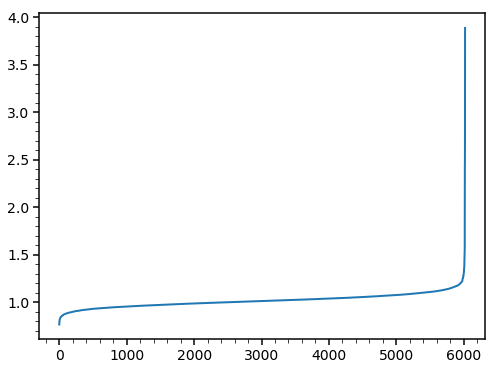

In [47]:
# append RUWE data

#[pmdec_error,dec,radial_velocity_error,parallax,
#teff_val,dist,parallax_error,phot_g_mean_flux,
#phot_bp_mean_flux_error,phot_variable_flag,ra,phot_bp_mean_flux,
#phot_g_mean_flux_error,radial_velocity,xsource_id,bp_rp,
#dec_error,pmra,pmdec,a_g_val,
#ra_error,pmra_error,phot_g_mean_mag,ruwe,
#source_id]
#print(len(srcnames))

RU = np.genfromtxt('/Users/mpetersen/Downloads/KGiantRUWE-result.csv',skip_header=1,delimiter=',')

ruwe = RU[:,23]
xsource = RU[:,14]
pmdece = RU[:,0]
dece = RU[:,1]
#gaiadict['gruwe'] = np.zeros(gaiadict['gpmdec_error'].size)

#for i in range(0,gaiadict['gpmdec_error'].size):
#    try:
#        print(RU[gaiadict['gpmdec_error'][i]==RU[:,0],0],gaiadict['gpmdec_error'][i])
#        gaiadict['gruwe'][i] = RU[gaiadict['gpmdec_error'][i]==RU[:,0],23]
#    except:
#        pass
    #print(RU[i,23],gaiadict['gdec'][gaiadict['gpmdec_error']==RU[i,0]])
    
plt.plot(ruwe[ruwe.argsort()])

print(np.where(ruwe>1.4))
print(xsource[np.where(ruwe>1.4)])

for indx in np.where(ruwe>1.4)[0]:
    #print(int(indx))
    vval = np.where(gaiadict['gdec']==dece[int(indx)])[0]#[0]
    print(X15['d'][vval])
    #print(vval)
    #print(dece[int(indx)])

print(gaiadict['gdec'])


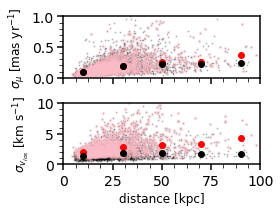

In [76]:

fig = plt.figure(figsize=(4,3))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


X15['FeH'].size,gaiadict['gra'].size

terror = np.sqrt(gaiadict['gpmra_error']*gaiadict['gpmra_error']*\
                 np.cos(gaiadict['gdec'])*np.cos(gaiadict['gdec']) +\
                 gaiadict['gpmdec_error']*gaiadict['gpmdec_error'])


ax1.scatter(X14['d'],terror,color='black',s=1.,alpha=0.2)
ax1.scatter(X14['d'][X14['FeH']<-1.8],terror[X14['FeH']<-1.8],color='pink',s=10.,alpha=0.2)

rbins = np.arange(10.,91,20)

for r in rbins:
    w = np.where((X14['d']>(r-10)) & (X14['d']<(r+10)) & (X14['FeH']<-1.8))
    ax1.scatter(r,np.nanmedian(terror[w]),color='red',s=35.)
    
    w = np.where((X14['d']>(r-10)) & (X14['d']<(r+10)) & (X14['FeH']>-1.8))
    ax1.scatter(r,np.nanmedian(terror[w]),color='black',s=35.)


ax1.axis([0.,100.,0.,1.0])
ax1.set_ylabel('$\\sigma_\\mu$ [mas yr$^{-1}$]',size=12)
ax1.set_xticklabels(())



ax2.scatter(X14['d'],X14['eHRV'],color='black',s=1.,alpha=0.2)
ax2.scatter(X14['d'][X14['FeH']<-1.8],X14['eHRV'][X14['FeH']<-1.8],color='pink',s=10.,alpha=0.2)

for r in rbins:
    w = np.where((X14['d']>(r-10)) & (X14['d']<(r+10)) & (X14['FeH']<-1.8))
    ax2.scatter(r,np.nanmedian(X14['eHRV'][w]),color='red',s=35.)
    
    w = np.where((X14['d']>(r-10)) & (X14['d']<(r+10)) & (X14['FeH']>-1.8))
    ax2.scatter(r,np.nanmedian(X14['eHRV'][w]),color='black',s=35.)


ax2.axis([0.,100.,0.,10.0])

ax2.set_ylabel('$\\sigma_{v_{los}}$ [km s$^{-1}$]',size=12)



ax2.set_xlabel('distance [kpc]',size=12)

plt.tight_layout()
plt.savefig('/Users/mpetersen/Downloads/kgianterrors.png',dpi=300)


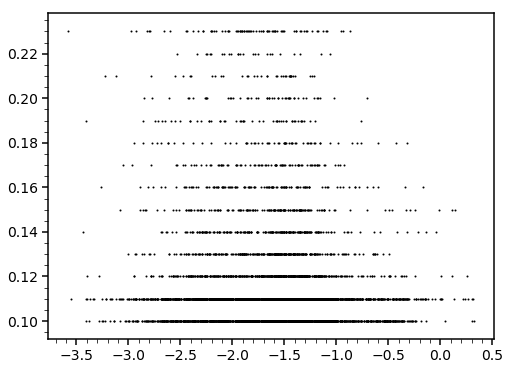

In [59]:
plt.scatter(X14['FeH'],X14['eFeH'],color='black',s=1.)

Note that I seem to have lost the technology to upload tables with source_id for matching. ra/dec seems possible?